In [ ]:
%pwd

'/workspace'

In [ ]:
from datasets import load_dataset
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig
import os
import matplotlib.pyplot as plt
from peft import LoraConfig, get_peft_model
import wandb
import transformers
from datetime import datetime
import logging

In [ ]:
def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) if len(x['input_ids'])<1024 else 1024 for x in tokenized_train_dataset ]
    lengths += [len(x['input_ids']) if len(x['input_ids'])<1024 else 1024 for x in tokenized_val_dataset]
    print(len(lengths))

    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )


# Load OpenOrca data and setup Accelerator

In [ ]:
dataset = load_dataset("ChunB1/OpenOrca_cot_only", split="train")
train_dataset = dataset.select(list(range(len(dataset)-5)))
eval_dataset = dataset.select(list(range(len(dataset)-5, len(dataset))))

print(dataset)
print(train_dataset)
print(eval_dataset)

Dataset({
    features: ['id', 'system_prompt', 'question', 'response'],
    num_rows: 141695
})
Dataset({
    features: ['id', 'system_prompt', 'question', 'response'],
    num_rows: 141690
})
Dataset({
    features: ['id', 'system_prompt', 'question', 'response'],
    num_rows: 5
})


In [ ]:
fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)
accelerator = Accelerator(fsdp_plugin=fsdp_plugin)
base_model_id = "microsoft/phi-2"


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


# Tokenize OpenOrca data

In [ ]:
def formatting_func(example):
    text = f"### Instruct: {example['question']}\n ### nOutput: {example['response']}"
    return text

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
    use_fast=False,
#    trust_remote_code=True
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

In [ ]:
tokenized_train_dataset = train_dataset.map(
    generate_and_tokenize_prompt,
    num_proc=os.cpu_count(),)
tokenized_val_dataset = eval_dataset.map(
    generate_and_tokenize_prompt,
    num_proc=os.cpu_count(),)

In [ ]:
tokenizer.decode(tokenized_train_dataset[0]["input_ids"])

"<|endoftext|>### Instruct: James runs a TV show and there are 5 main characters and 4 minor characters. He pays the minor characters $15,000 each episode. He paid the major characters three times as much. How much does he pay per episode? Let's be accurate as possible.\n ### nOutput: James pays the minor characters $15,000 each episode. Since there are 4 minor characters, he pays them a total of 4 * $15,000 = $60,000 per episode.\n\nThe major characters are paid three times as much. So, each major character gets paid 3 * $15,000 = $45,000 per episode.\n\nThere are 5 main characters, so he pays them a total of 5 * $45,000 = $225,000 per episode.\n\nIn total, James pays $225,000 (major characters) + $60,000 (minor characters) = $285,000 per episode."

141695


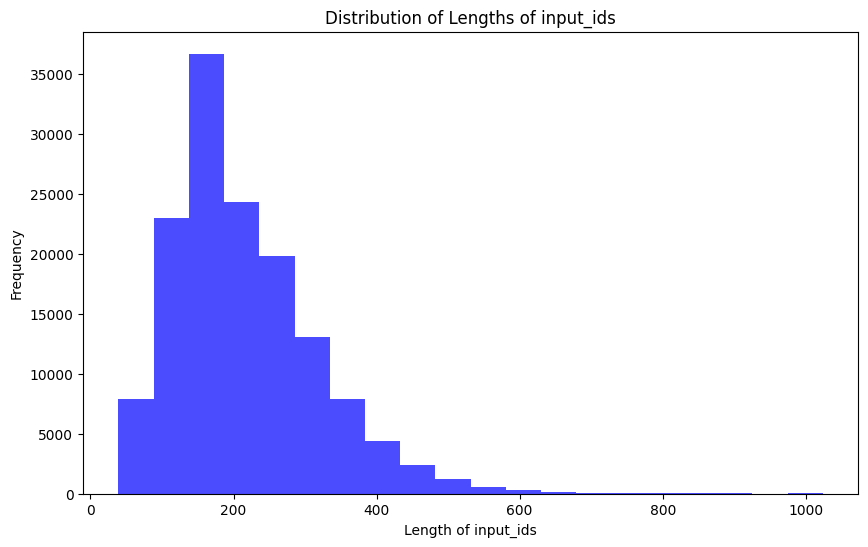

In [ ]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [ ]:
tokenizer.pad_token = tokenizer.eos_token
tokenizer.truncation_side = "right"

max_length = 512

def generate_and_tokenize_prompt_truncate(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
tokenized_train_dataset = train_dataset.map(
    generate_and_tokenize_prompt_truncate,
    num_proc=os.cpu_count(),)
tokenized_val_dataset = eval_dataset.map(
    generate_and_tokenize_prompt_truncate,
    num_proc=os.cpu_count(),)

num_proc must be <= 5. Reducing num_proc to 5 for dataset of size 5.


141695


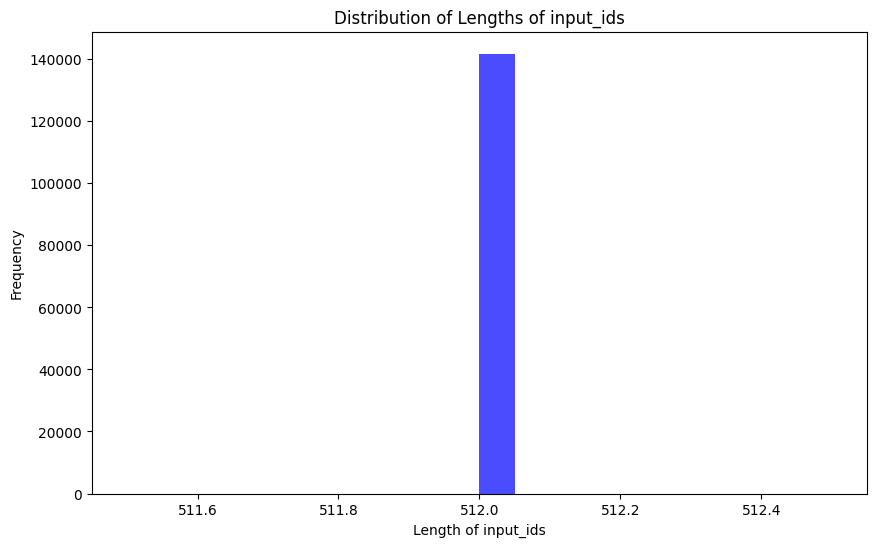

In [ ]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [ ]:
tokenizer.decode(tokenized_train_dataset[0]["input_ids"])

"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext

# Base model performance

In [ ]:
# Answer: [79, 70, 29, 75]
eval_prompt = """Instruct: Apply a function to the final input list to generate the output list. Use any preceding inputs and outputs as examples. User: [82, 15, 69, 90] Assistant: [82, 15, 69] User: [52, 46, 50, 31] Assistant: [52, 46, 50] User: [33, 9, 4] Assistant: [33, 9] User: [79, 70, 29, 75, 8] Assistant:
Output:"""

In [ ]:
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
    trust_remote_code=True,
    use_fast=False,
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))

In [ ]:
eval_tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2", trust_remote_code=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
model_input = eval_tokenizer(eval_prompt, return_tensors="pt", return_attention_mask=False)

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_length=200)[0], skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Instruct: Apply a function to the final input list to generate the output list. Use any preceding inputs and outputs as examples. User: [82, 15, 69, 90] Assistant: [82, 15, 69] User: [52, 46, 50, 31] Assistant: [52, 46, 50] User: [33, 9, 4] Assistant: [33, 9] User: [79, 70, 29, 75, 8] Assistant:
Output: [79, 70, 29, 75, 8]


# Lora config

In [ ]:
# Test FlashAttention-2 later
model = AutoModelForCausalLM.from_pretrained(base_model_id,
                                             trust_remote_code=True,
                                             torch_dtype=torch.float16,
                                        attn_implementation="flash_attention_2",
                                        quantization_config=BitsAndBytesConfig(
        load_in_8bit=True,
    ),)

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
print_trainable_parameters(model)


`r` is the rank of the low-rank matrix used in the adapters, which thus controls the number of parameters trained. A higher rank will allow for more expressivity, but there is a compute tradeoff.

`alpha` is the scaling factor for the learned weights. The weight matrix is scaled by `alpha/r`, and thus a higher value for `alpha` assigns more weight to the LoRA activations.

The values used in the QLoRA paper were `r=64` and `lora_alpha=16`, and these are said to generalize well, but we will use `r=32` and `lora_alpha=64` so that we have more emphasis on the new fine-tuned data while also reducing computational complexity.

In [ ]:
# set r=64 for 512 max_length to experiment
config = LoraConfig(
    r=64,
    lora_alpha=64,
    target_modules='all-linear',
    bias="none",
    lora_dropout=0.05,
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 94371840 || all params: 2874055680 || trainable%: 3.2835773035545364


# Instruct Tuning

In [ ]:
logging.getLogger("transformers").setLevel(logging.ERROR)
os.environ["WANDB_PROJECT"]="phi2-OpenOrca"
os.environ["WANDB_LOG_MODEL"] = "checkpoint"

In [ ]:
model = accelerator.prepare_model(model)
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [ ]:
run_name = "phi2_5"
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=2,
        num_train_epochs=1,
        output_dir=output_dir,
        warmup_steps=1,
        gradient_accumulation_steps=1,
        learning_rate=2.5e-5,
        optim="paged_adamw_8bit",
        logging_steps=25,
        logging_dir="./logs",
        save_strategy="steps",
        save_steps=1000,
        save_total_limit = 3,
        evaluation_strategy="steps",
        eval_steps=100,
        do_eval=True,
        report_to="wandb",
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings
trainer.train()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


{'loss': 1.36, 'grad_norm': 4.61237096786499, 'learning_rate': 2.4991530687143584e-05, 'epoch': 0.0}
{'loss': 1.2243, 'grad_norm': 5.4032464027404785, 'learning_rate': 2.4982708486251483e-05, 'epoch': 0.0}
{'loss': 1.3262, 'grad_norm': 5.751614570617676, 'learning_rate': 2.4973886285359383e-05, 'epoch': 0.0}
{'loss': 1.2446, 'grad_norm': 5.142204761505127, 'learning_rate': 2.496506408446728e-05, 'epoch': 0.0}
{'eval_loss': 1.0078521966934204, 'eval_runtime': 0.3367, 'eval_samples_per_second': 14.851, 'eval_steps_per_second': 2.97, 'epoch': 0.0}
{'loss': 1.1814, 'grad_norm': 3.596472978591919, 'learning_rate': 2.495624188357518e-05, 'epoch': 0.0}
{'loss': 1.2037, 'grad_norm': 5.405838489532471, 'learning_rate': 2.494741968268308e-05, 'epoch': 0.0}
{'loss': 1.219, 'grad_norm': 7.302859783172607, 'learning_rate': 2.493859748179098e-05, 'epoch': 0.0}
{'loss': 1.1045, 'grad_norm': 5.691873550415039, 'learning_rate': 2.4929775280898878e-05, 'epoch': 0.0}
{'eval_loss': 0.927329421043396, 'eva

wandb: Adding directory to artifact (./phi2_5/checkpoint-1000)... Done. 0.8s


{'loss': 1.0337, 'grad_norm': 2.4583821296691895, 'learning_rate': 2.4638642651459545e-05, 'epoch': 0.01}
{'loss': 1.0098, 'grad_norm': 4.2648606300354, 'learning_rate': 2.4629820450567444e-05, 'epoch': 0.01}
{'loss': 0.964, 'grad_norm': 2.7223124504089355, 'learning_rate': 2.4620998249675346e-05, 'epoch': 0.02}
{'loss': 1.064, 'grad_norm': 3.471320390701294, 'learning_rate': 2.4612176048783242e-05, 'epoch': 0.02}
{'eval_loss': 0.7387210130691528, 'eval_runtime': 0.3408, 'eval_samples_per_second': 14.671, 'eval_steps_per_second': 2.934, 'epoch': 0.02}
{'loss': 1.0232, 'grad_norm': 3.9093782901763916, 'learning_rate': 2.460335384789114e-05, 'epoch': 0.02}
{'loss': 0.9545, 'grad_norm': 3.993408203125, 'learning_rate': 2.459453164699904e-05, 'epoch': 0.02}
{'loss': 0.997, 'grad_norm': 3.7476861476898193, 'learning_rate': 2.4585709446106943e-05, 'epoch': 0.02}
{'loss': 0.9695, 'grad_norm': 3.5189270973205566, 'learning_rate': 2.457688724521484e-05, 'epoch': 0.02}
{'eval_loss': 0.7262232899

wandb: Adding directory to artifact (./phi2_5/checkpoint-2000)... Done. 0.8s


{'loss': 0.8747, 'grad_norm': 2.273651361465454, 'learning_rate': 2.428575461577551e-05, 'epoch': 0.03}
{'loss': 0.9532, 'grad_norm': 2.865544319152832, 'learning_rate': 2.4276932414883408e-05, 'epoch': 0.03}
{'loss': 0.998, 'grad_norm': 3.486262559890747, 'learning_rate': 2.4268110213991303e-05, 'epoch': 0.03}
{'loss': 0.9473, 'grad_norm': 2.7404122352600098, 'learning_rate': 2.4259288013099206e-05, 'epoch': 0.03}
{'eval_loss': 0.6745705604553223, 'eval_runtime': 0.338, 'eval_samples_per_second': 14.793, 'eval_steps_per_second': 2.959, 'epoch': 0.03}
{'loss': 0.9413, 'grad_norm': 3.6465401649475098, 'learning_rate': 2.4250465812207105e-05, 'epoch': 0.03}
{'loss': 0.9712, 'grad_norm': 2.5364184379577637, 'learning_rate': 2.4241643611315004e-05, 'epoch': 0.03}
{'loss': 0.9807, 'grad_norm': 3.267773389816284, 'learning_rate': 2.42328214104229e-05, 'epoch': 0.03}
{'loss': 0.9091, 'grad_norm': 2.0823380947113037, 'learning_rate': 2.4223999209530802e-05, 'epoch': 0.03}
{'eval_loss': 0.66934

wandb: Adding directory to artifact (./phi2_5/checkpoint-3000)... Done. 0.8s


{'loss': 0.8912, 'grad_norm': 2.1279497146606445, 'learning_rate': 2.393286658009147e-05, 'epoch': 0.04}
{'loss': 0.9177, 'grad_norm': 2.266521692276001, 'learning_rate': 2.392404437919937e-05, 'epoch': 0.04}
{'loss': 0.872, 'grad_norm': 2.1150999069213867, 'learning_rate': 2.3915222178307267e-05, 'epoch': 0.04}
{'loss': 0.9171, 'grad_norm': 2.2045931816101074, 'learning_rate': 2.3906399977415166e-05, 'epoch': 0.04}
{'eval_loss': 0.665885865688324, 'eval_runtime': 0.3366, 'eval_samples_per_second': 14.854, 'eval_steps_per_second': 2.971, 'epoch': 0.04}
{'loss': 0.809, 'grad_norm': 2.0684003829956055, 'learning_rate': 2.3897577776523065e-05, 'epoch': 0.04}
{'loss': 0.8157, 'grad_norm': 2.8224709033966064, 'learning_rate': 2.3888755575630964e-05, 'epoch': 0.04}
{'loss': 0.9752, 'grad_norm': 3.907127618789673, 'learning_rate': 2.3879933374738863e-05, 'epoch': 0.04}
{'loss': 0.9319, 'grad_norm': 2.4734203815460205, 'learning_rate': 2.3871111173846763e-05, 'epoch': 0.05}
{'eval_loss': 0.663

wandb: Adding directory to artifact (./phi2_5/checkpoint-4000)... Done. 0.8s


{'loss': 0.8655, 'grad_norm': 1.7760342359542847, 'learning_rate': 2.3579978544407433e-05, 'epoch': 0.06}
{'loss': 0.8259, 'grad_norm': 2.297441005706787, 'learning_rate': 2.357115634351533e-05, 'epoch': 0.06}
{'loss': 0.8584, 'grad_norm': 2.6548526287078857, 'learning_rate': 2.356233414262323e-05, 'epoch': 0.06}
{'loss': 0.9202, 'grad_norm': 1.9811593294143677, 'learning_rate': 2.355351194173113e-05, 'epoch': 0.06}
{'eval_loss': 0.6596285104751587, 'eval_runtime': 0.3348, 'eval_samples_per_second': 14.936, 'eval_steps_per_second': 2.987, 'epoch': 0.06}
{'loss': 0.964, 'grad_norm': 3.015800714492798, 'learning_rate': 2.3544689740839026e-05, 'epoch': 0.06}
{'loss': 0.9578, 'grad_norm': 2.3544442653656006, 'learning_rate': 2.3535867539946925e-05, 'epoch': 0.06}
{'loss': 0.9657, 'grad_norm': 1.91901433467865, 'learning_rate': 2.3527045339054827e-05, 'epoch': 0.06}
{'loss': 1.0378, 'grad_norm': 2.210444450378418, 'learning_rate': 2.3518223138162726e-05, 'epoch': 0.06}
{'eval_loss': 0.66279

wandb: Adding directory to artifact (./phi2_5/checkpoint-5000)... Done. 0.8s


{'loss': 0.8106, 'grad_norm': 2.064763069152832, 'learning_rate': 2.3227090508723393e-05, 'epoch': 0.07}
{'loss': 0.9229, 'grad_norm': 4.106919288635254, 'learning_rate': 2.3218268307831292e-05, 'epoch': 0.07}
{'loss': 0.8716, 'grad_norm': 1.9355674982070923, 'learning_rate': 2.320944610693919e-05, 'epoch': 0.07}
{'loss': 0.8831, 'grad_norm': 5.485193729400635, 'learning_rate': 2.320062390604709e-05, 'epoch': 0.07}
{'eval_loss': 0.6524415016174316, 'eval_runtime': 0.3413, 'eval_samples_per_second': 14.651, 'eval_steps_per_second': 2.93, 'epoch': 0.07}
{'loss': 0.8916, 'grad_norm': 3.680248260498047, 'learning_rate': 2.319180170515499e-05, 'epoch': 0.07}
{'loss': 0.8982, 'grad_norm': 1.9715707302093506, 'learning_rate': 2.318297950426289e-05, 'epoch': 0.07}
{'loss': 0.9279, 'grad_norm': 2.6471803188323975, 'learning_rate': 2.3174157303370788e-05, 'epoch': 0.07}
{'loss': 0.9501, 'grad_norm': 10.1384916305542, 'learning_rate': 2.3165335102478687e-05, 'epoch': 0.07}
{'eval_loss': 0.6555467

wandb: Adding directory to artifact (./phi2_5/checkpoint-6000)... Done. 0.8s


{'loss': 0.9086, 'grad_norm': 2.383378267288208, 'learning_rate': 2.2874202473039353e-05, 'epoch': 0.09}
{'loss': 0.8464, 'grad_norm': 2.102550745010376, 'learning_rate': 2.2865380272147256e-05, 'epoch': 0.09}
{'loss': 0.8773, 'grad_norm': 2.9318466186523438, 'learning_rate': 2.285655807125515e-05, 'epoch': 0.09}
{'loss': 0.8319, 'grad_norm': 1.7163751125335693, 'learning_rate': 2.284773587036305e-05, 'epoch': 0.09}
{'eval_loss': 0.6501935124397278, 'eval_runtime': 0.3473, 'eval_samples_per_second': 14.399, 'eval_steps_per_second': 2.88, 'epoch': 0.09}
{'loss': 0.7961, 'grad_norm': 2.527282953262329, 'learning_rate': 2.2838913669470953e-05, 'epoch': 0.09}
{'loss': 0.9658, 'grad_norm': 2.4339993000030518, 'learning_rate': 2.2830091468578852e-05, 'epoch': 0.09}
{'loss': 0.7994, 'grad_norm': 2.439237594604492, 'learning_rate': 2.2821269267686748e-05, 'epoch': 0.09}
{'loss': 0.9129, 'grad_norm': 2.167513132095337, 'learning_rate': 2.2812447066794647e-05, 'epoch': 0.09}
{'eval_loss': 0.6604

wandb: Adding directory to artifact (./phi2_5/checkpoint-7000)... Done. 0.8s


{'loss': 0.7858, 'grad_norm': 1.8762394189834595, 'learning_rate': 2.2521314437355317e-05, 'epoch': 0.1}
{'loss': 0.9955, 'grad_norm': 2.176971435546875, 'learning_rate': 2.2512492236463216e-05, 'epoch': 0.1}
{'loss': 0.8839, 'grad_norm': 2.5939221382141113, 'learning_rate': 2.2503670035571115e-05, 'epoch': 0.1}
{'loss': 0.8491, 'grad_norm': 1.904988169670105, 'learning_rate': 2.2494847834679014e-05, 'epoch': 0.1}
{'eval_loss': 0.6546657681465149, 'eval_runtime': 0.3361, 'eval_samples_per_second': 14.876, 'eval_steps_per_second': 2.975, 'epoch': 0.1}
{'loss': 0.8072, 'grad_norm': 1.7761510610580444, 'learning_rate': 2.2486025633786914e-05, 'epoch': 0.1}
{'loss': 0.9126, 'grad_norm': 2.192199230194092, 'learning_rate': 2.2477203432894813e-05, 'epoch': 0.1}
{'loss': 0.9155, 'grad_norm': 1.971937656402588, 'learning_rate': 2.2468381232002712e-05, 'epoch': 0.1}
{'loss': 0.8595, 'grad_norm': 3.145341157913208, 'learning_rate': 2.245955903111061e-05, 'epoch': 0.1}
{'eval_loss': 0.64566284418

wandb: Adding directory to artifact (./phi2_5/checkpoint-8000)... Done. 0.8s


{'loss': 0.8517, 'grad_norm': 2.7893083095550537, 'learning_rate': 2.216842640167128e-05, 'epoch': 0.11}
{'loss': 0.8885, 'grad_norm': 2.8178651332855225, 'learning_rate': 2.2159604200779177e-05, 'epoch': 0.11}
{'loss': 0.8541, 'grad_norm': 1.658545970916748, 'learning_rate': 2.2150781999887076e-05, 'epoch': 0.11}
{'loss': 0.8754, 'grad_norm': 2.1603424549102783, 'learning_rate': 2.2141959798994978e-05, 'epoch': 0.11}
{'eval_loss': 0.6492145657539368, 'eval_runtime': 0.3378, 'eval_samples_per_second': 14.801, 'eval_steps_per_second': 2.96, 'epoch': 0.11}
{'loss': 0.9504, 'grad_norm': 2.7012171745300293, 'learning_rate': 2.2133137598102874e-05, 'epoch': 0.11}
{'loss': 0.838, 'grad_norm': 3.0306897163391113, 'learning_rate': 2.2124315397210773e-05, 'epoch': 0.12}
{'loss': 0.8812, 'grad_norm': 2.5192766189575195, 'learning_rate': 2.2115493196318672e-05, 'epoch': 0.12}
{'loss': 0.827, 'grad_norm': 3.0508599281311035, 'learning_rate': 2.2106670995426575e-05, 'epoch': 0.12}
{'eval_loss': 0.6

wandb: Adding directory to artifact (./phi2_5/checkpoint-9000)... Done. 0.8s


{'loss': 0.8879, 'grad_norm': 2.2786312103271484, 'learning_rate': 2.181553836598724e-05, 'epoch': 0.13}
{'loss': 0.8676, 'grad_norm': 1.587500810623169, 'learning_rate': 2.180671616509514e-05, 'epoch': 0.13}
{'loss': 0.848, 'grad_norm': 1.3856768608093262, 'learning_rate': 2.179789396420304e-05, 'epoch': 0.13}
{'loss': 0.8356, 'grad_norm': 3.563880443572998, 'learning_rate': 2.1789071763310935e-05, 'epoch': 0.13}
{'eval_loss': 0.6331917643547058, 'eval_runtime': 0.3316, 'eval_samples_per_second': 15.077, 'eval_steps_per_second': 3.015, 'epoch': 0.13}
{'loss': 0.8371, 'grad_norm': 1.851603627204895, 'learning_rate': 2.1780249562418838e-05, 'epoch': 0.13}
{'loss': 0.8476, 'grad_norm': 1.9589014053344727, 'learning_rate': 2.1771427361526737e-05, 'epoch': 0.13}
{'loss': 0.8848, 'grad_norm': 3.7391154766082764, 'learning_rate': 2.1762605160634636e-05, 'epoch': 0.13}
{'loss': 0.802, 'grad_norm': 1.6932631731033325, 'learning_rate': 2.175378295974253e-05, 'epoch': 0.13}
{'eval_loss': 0.63677

wandb: Adding directory to artifact (./phi2_5/checkpoint-10000)... Done. 0.8s


{'loss': 0.7988, 'grad_norm': 1.9940274953842163, 'learning_rate': 2.1462650330303202e-05, 'epoch': 0.14}
{'loss': 0.8641, 'grad_norm': 1.8209415674209595, 'learning_rate': 2.14538281294111e-05, 'epoch': 0.14}
{'loss': 0.9008, 'grad_norm': 1.4899449348449707, 'learning_rate': 2.1445005928519e-05, 'epoch': 0.14}
{'loss': 0.8896, 'grad_norm': 2.7019362449645996, 'learning_rate': 2.14361837276269e-05, 'epoch': 0.14}
{'eval_loss': 0.6413248777389526, 'eval_runtime': 0.3499, 'eval_samples_per_second': 14.289, 'eval_steps_per_second': 2.858, 'epoch': 0.14}
{'loss': 0.8419, 'grad_norm': 2.1508350372314453, 'learning_rate': 2.1427361526734798e-05, 'epoch': 0.14}
{'loss': 0.8341, 'grad_norm': 2.3345084190368652, 'learning_rate': 2.1418539325842697e-05, 'epoch': 0.14}
{'loss': 0.8828, 'grad_norm': 1.5647543668746948, 'learning_rate': 2.1409717124950596e-05, 'epoch': 0.14}
{'loss': 0.8028, 'grad_norm': 1.504256010055542, 'learning_rate': 2.1400894924058495e-05, 'epoch': 0.14}
{'eval_loss': 0.6471

wandb: Adding directory to artifact (./phi2_5/checkpoint-11000)... Done. 0.8s


{'loss': 0.7803, 'grad_norm': 1.5196380615234375, 'learning_rate': 2.1109762294619166e-05, 'epoch': 0.16}
{'loss': 0.8624, 'grad_norm': 2.1283628940582275, 'learning_rate': 2.1100940093727065e-05, 'epoch': 0.16}
{'loss': 0.7873, 'grad_norm': 1.338996171951294, 'learning_rate': 2.109211789283496e-05, 'epoch': 0.16}
{'loss': 0.9009, 'grad_norm': 1.2501263618469238, 'learning_rate': 2.1083295691942863e-05, 'epoch': 0.16}
{'eval_loss': 0.6306459903717041, 'eval_runtime': 0.3288, 'eval_samples_per_second': 15.209, 'eval_steps_per_second': 3.042, 'epoch': 0.16}
{'loss': 0.7754, 'grad_norm': 1.459619164466858, 'learning_rate': 2.1074473491050762e-05, 'epoch': 0.16}
{'loss': 0.8208, 'grad_norm': 1.447356939315796, 'learning_rate': 2.1065651290158658e-05, 'epoch': 0.16}
{'loss': 0.8818, 'grad_norm': 1.7122180461883545, 'learning_rate': 2.1056829089266557e-05, 'epoch': 0.16}
{'loss': 0.819, 'grad_norm': 1.2054259777069092, 'learning_rate': 2.104800688837446e-05, 'epoch': 0.16}
{'eval_loss': 0.63

wandb: Adding directory to artifact (./phi2_5/checkpoint-12000)... Done. 0.8s


{'loss': 0.874, 'grad_norm': 1.3740030527114868, 'learning_rate': 2.0756874258935126e-05, 'epoch': 0.17}
{'loss': 0.8329, 'grad_norm': 1.5999948978424072, 'learning_rate': 2.0748052058043025e-05, 'epoch': 0.17}
{'loss': 0.7676, 'grad_norm': 1.2881220579147339, 'learning_rate': 2.0739229857150924e-05, 'epoch': 0.17}
{'loss': 0.851, 'grad_norm': 1.8367525339126587, 'learning_rate': 2.0730407656258823e-05, 'epoch': 0.17}
{'eval_loss': 0.6306813359260559, 'eval_runtime': 0.325, 'eval_samples_per_second': 15.383, 'eval_steps_per_second': 3.077, 'epoch': 0.17}
{'loss': 0.8547, 'grad_norm': 1.4035487174987793, 'learning_rate': 2.0721585455366722e-05, 'epoch': 0.17}
{'loss': 0.8266, 'grad_norm': 2.7962806224823, 'learning_rate': 2.071276325447462e-05, 'epoch': 0.17}
{'loss': 0.7751, 'grad_norm': 1.1235166788101196, 'learning_rate': 2.070394105358252e-05, 'epoch': 0.17}
{'loss': 0.8818, 'grad_norm': 2.127516746520996, 'learning_rate': 2.069511885269042e-05, 'epoch': 0.17}
{'eval_loss': 0.632012

wandb: Adding directory to artifact (./phi2_5/checkpoint-13000)... Done. 0.8s


{'loss': 0.8365, 'grad_norm': 1.2767471075057983, 'learning_rate': 2.0403986223251086e-05, 'epoch': 0.18}
{'loss': 0.7807, 'grad_norm': 1.163779854774475, 'learning_rate': 2.0395164022358985e-05, 'epoch': 0.18}
{'loss': 0.8435, 'grad_norm': 1.7924458980560303, 'learning_rate': 2.0386341821466888e-05, 'epoch': 0.18}
{'loss': 0.8303, 'grad_norm': 1.6195331811904907, 'learning_rate': 2.0377519620574784e-05, 'epoch': 0.18}
{'eval_loss': 0.633228063583374, 'eval_runtime': 0.3394, 'eval_samples_per_second': 14.733, 'eval_steps_per_second': 2.947, 'epoch': 0.18}
{'loss': 0.8887, 'grad_norm': 1.520521640777588, 'learning_rate': 2.0368697419682683e-05, 'epoch': 0.19}
{'loss': 0.7558, 'grad_norm': 1.7713578939437866, 'learning_rate': 2.0359875218790582e-05, 'epoch': 0.19}
{'loss': 0.8023, 'grad_norm': 2.7959651947021484, 'learning_rate': 2.0351053017898484e-05, 'epoch': 0.19}
{'loss': 0.9107, 'grad_norm': 1.3432592153549194, 'learning_rate': 2.034223081700638e-05, 'epoch': 0.19}
{'eval_loss': 0.

wandb: Adding directory to artifact (./phi2_5/checkpoint-14000)... Done. 0.8s


{'loss': 0.9235, 'grad_norm': 1.2656258344650269, 'learning_rate': 2.005109818756705e-05, 'epoch': 0.2}
{'loss': 0.942, 'grad_norm': 1.93246591091156, 'learning_rate': 2.004227598667495e-05, 'epoch': 0.2}
{'loss': 0.8837, 'grad_norm': 1.3091343641281128, 'learning_rate': 2.0033453785782848e-05, 'epoch': 0.2}
{'loss': 0.9891, 'grad_norm': 1.7894338369369507, 'learning_rate': 2.0024631584890747e-05, 'epoch': 0.2}
{'eval_loss': 0.625619649887085, 'eval_runtime': 0.3523, 'eval_samples_per_second': 14.191, 'eval_steps_per_second': 2.838, 'epoch': 0.2}
{'loss': 0.8373, 'grad_norm': 1.4018105268478394, 'learning_rate': 2.0015809383998646e-05, 'epoch': 0.2}
{'loss': 0.8745, 'grad_norm': 2.0279927253723145, 'learning_rate': 2.0006987183106546e-05, 'epoch': 0.2}
{'loss': 0.8709, 'grad_norm': 1.590969443321228, 'learning_rate': 1.999816498221444e-05, 'epoch': 0.2}
{'loss': 0.8903, 'grad_norm': 1.729902744293213, 'learning_rate': 1.9989342781322344e-05, 'epoch': 0.2}
{'eval_loss': 0.62732964754104

wandb: Adding directory to artifact (./phi2_5/checkpoint-15000)... Done. 0.8s


{'loss': 0.8703, 'grad_norm': 1.191887378692627, 'learning_rate': 1.969821015188301e-05, 'epoch': 0.21}
{'loss': 0.8348, 'grad_norm': 1.7127856016159058, 'learning_rate': 1.9689387950990913e-05, 'epoch': 0.21}
{'loss': 0.763, 'grad_norm': 1.2595672607421875, 'learning_rate': 1.968056575009881e-05, 'epoch': 0.21}
{'loss': 0.895, 'grad_norm': 2.0113494396209717, 'learning_rate': 1.9671743549206708e-05, 'epoch': 0.21}
{'eval_loss': 0.6226902008056641, 'eval_runtime': 0.3322, 'eval_samples_per_second': 15.05, 'eval_steps_per_second': 3.01, 'epoch': 0.21}
{'loss': 0.8548, 'grad_norm': 1.5242407321929932, 'learning_rate': 1.9662921348314607e-05, 'epoch': 0.21}
{'loss': 0.7988, 'grad_norm': 1.264363408088684, 'learning_rate': 1.9654099147422506e-05, 'epoch': 0.21}
{'loss': 0.8224, 'grad_norm': 1.2718623876571655, 'learning_rate': 1.9645276946530405e-05, 'epoch': 0.21}
{'loss': 0.8445, 'grad_norm': 1.4001185894012451, 'learning_rate': 1.9636454745638304e-05, 'epoch': 0.21}
{'eval_loss': 0.6240

wandb: Adding directory to artifact (./phi2_5/checkpoint-16000)... Done. 0.8s


{'loss': 0.884, 'grad_norm': 1.6438008546829224, 'learning_rate': 1.9345322116198974e-05, 'epoch': 0.23}
{'loss': 0.8664, 'grad_norm': 1.4526221752166748, 'learning_rate': 1.933649991530687e-05, 'epoch': 0.23}
{'loss': 0.8145, 'grad_norm': 1.3893808126449585, 'learning_rate': 1.9327677714414772e-05, 'epoch': 0.23}
{'loss': 0.8548, 'grad_norm': 1.6581565141677856, 'learning_rate': 1.931885551352267e-05, 'epoch': 0.23}
{'eval_loss': 0.6321386694908142, 'eval_runtime': 0.3439, 'eval_samples_per_second': 14.54, 'eval_steps_per_second': 2.908, 'epoch': 0.23}
{'loss': 0.817, 'grad_norm': 1.5292774438858032, 'learning_rate': 1.9310033312630567e-05, 'epoch': 0.23}
{'loss': 0.8433, 'grad_norm': 1.5389080047607422, 'learning_rate': 1.930121111173847e-05, 'epoch': 0.23}
{'loss': 0.8191, 'grad_norm': 1.2529065608978271, 'learning_rate': 1.929238891084637e-05, 'epoch': 0.23}
{'loss': 0.8703, 'grad_norm': 1.302910566329956, 'learning_rate': 1.9283566709954268e-05, 'epoch': 0.23}
{'eval_loss': 0.6271

wandb: Adding directory to artifact (./phi2_5/checkpoint-17000)... Done. 0.8s


{'loss': 0.9394, 'grad_norm': 1.25871741771698, 'learning_rate': 1.8992434080514935e-05, 'epoch': 0.24}
{'loss': 0.8326, 'grad_norm': 1.0305142402648926, 'learning_rate': 1.8983611879622834e-05, 'epoch': 0.24}
{'loss': 0.8473, 'grad_norm': 1.3331334590911865, 'learning_rate': 1.8974789678730733e-05, 'epoch': 0.24}
{'loss': 0.8947, 'grad_norm': 1.7185789346694946, 'learning_rate': 1.8965967477838632e-05, 'epoch': 0.24}
{'eval_loss': 0.6246348023414612, 'eval_runtime': 0.3344, 'eval_samples_per_second': 14.952, 'eval_steps_per_second': 2.99, 'epoch': 0.24}
{'loss': 0.8525, 'grad_norm': 1.3703850507736206, 'learning_rate': 1.895714527694653e-05, 'epoch': 0.24}
{'loss': 0.8023, 'grad_norm': 1.1823209524154663, 'learning_rate': 1.894832307605443e-05, 'epoch': 0.24}
{'loss': 0.986, 'grad_norm': 1.2653858661651611, 'learning_rate': 1.893950087516233e-05, 'epoch': 0.24}
{'loss': 0.9001, 'grad_norm': 1.3058950901031494, 'learning_rate': 1.8930678674270228e-05, 'epoch': 0.24}
{'eval_loss': 0.627

wandb: Adding directory to artifact (./phi2_5/checkpoint-18000)... Done. 0.8s


{'loss': 0.86, 'grad_norm': 1.2962169647216797, 'learning_rate': 1.86395460448309e-05, 'epoch': 0.25}
{'loss': 0.8825, 'grad_norm': 1.1380187273025513, 'learning_rate': 1.8630723843938798e-05, 'epoch': 0.25}
{'loss': 0.8175, 'grad_norm': 1.2532403469085693, 'learning_rate': 1.8621901643046697e-05, 'epoch': 0.26}
{'loss': 0.8526, 'grad_norm': 1.457921028137207, 'learning_rate': 1.8613079442154592e-05, 'epoch': 0.26}
{'eval_loss': 0.6236489415168762, 'eval_runtime': 0.3434, 'eval_samples_per_second': 14.561, 'eval_steps_per_second': 2.912, 'epoch': 0.26}
{'loss': 0.8672, 'grad_norm': 1.4444739818572998, 'learning_rate': 1.8604257241262495e-05, 'epoch': 0.26}
{'loss': 0.9191, 'grad_norm': 1.7137219905853271, 'learning_rate': 1.8595435040370394e-05, 'epoch': 0.26}
{'loss': 0.8431, 'grad_norm': 1.5319403409957886, 'learning_rate': 1.858661283947829e-05, 'epoch': 0.26}
{'loss': 0.8235, 'grad_norm': 1.2577111721038818, 'learning_rate': 1.857779063858619e-05, 'epoch': 0.26}
{'eval_loss': 0.619

wandb: Adding directory to artifact (./phi2_5/checkpoint-19000)... Done. 0.8s


{'loss': 0.8264, 'grad_norm': 1.3425283432006836, 'learning_rate': 1.828665800914686e-05, 'epoch': 0.27}
{'loss': 0.8107, 'grad_norm': 1.8673312664031982, 'learning_rate': 1.8277835808254758e-05, 'epoch': 0.27}
{'loss': 0.9037, 'grad_norm': 1.1965126991271973, 'learning_rate': 1.8269013607362657e-05, 'epoch': 0.27}
{'loss': 0.8069, 'grad_norm': 1.2988954782485962, 'learning_rate': 1.8260191406470556e-05, 'epoch': 0.27}
{'eval_loss': 0.6160193085670471, 'eval_runtime': 0.3446, 'eval_samples_per_second': 14.51, 'eval_steps_per_second': 2.902, 'epoch': 0.27}
{'loss': 0.8107, 'grad_norm': 3.9734256267547607, 'learning_rate': 1.8251369205578455e-05, 'epoch': 0.27}
{'loss': 0.8266, 'grad_norm': 1.8466613292694092, 'learning_rate': 1.8242547004686354e-05, 'epoch': 0.27}
{'loss': 0.8328, 'grad_norm': 1.2127599716186523, 'learning_rate': 1.8233724803794253e-05, 'epoch': 0.27}
{'loss': 0.856, 'grad_norm': 1.4967930316925049, 'learning_rate': 1.8224902602902152e-05, 'epoch': 0.27}
{'eval_loss': 0

wandb: Adding directory to artifact (./phi2_5/checkpoint-20000)... Done. 0.8s


{'loss': 0.8067, 'grad_norm': 1.52046799659729, 'learning_rate': 1.7933769973462823e-05, 'epoch': 0.28}
{'loss': 0.7872, 'grad_norm': 1.4750981330871582, 'learning_rate': 1.7924947772570718e-05, 'epoch': 0.28}
{'loss': 0.8489, 'grad_norm': 1.1566623449325562, 'learning_rate': 1.7916125571678617e-05, 'epoch': 0.28}
{'loss': 0.7837, 'grad_norm': 1.9085794687271118, 'learning_rate': 1.790730337078652e-05, 'epoch': 0.28}
{'eval_loss': 0.6138734817504883, 'eval_runtime': 0.322, 'eval_samples_per_second': 15.528, 'eval_steps_per_second': 3.106, 'epoch': 0.28}
{'loss': 0.8285, 'grad_norm': 1.0072293281555176, 'learning_rate': 1.7898481169894416e-05, 'epoch': 0.28}
{'loss': 0.7131, 'grad_norm': 1.3387463092803955, 'learning_rate': 1.7889658969002315e-05, 'epoch': 0.28}
{'loss': 0.7616, 'grad_norm': 0.9972432851791382, 'learning_rate': 1.7880836768110214e-05, 'epoch': 0.28}
{'loss': 0.8167, 'grad_norm': 1.340014100074768, 'learning_rate': 1.7872014567218116e-05, 'epoch': 0.29}
{'eval_loss': 0.6

wandb: Adding directory to artifact (./phi2_5/checkpoint-21000)... Done. 0.8s


{'loss': 0.8478, 'grad_norm': 1.0543633699417114, 'learning_rate': 1.7580881937778783e-05, 'epoch': 0.3}
{'loss': 0.8634, 'grad_norm': 1.7057609558105469, 'learning_rate': 1.7572059736886682e-05, 'epoch': 0.3}
{'loss': 0.8264, 'grad_norm': 0.9449329972267151, 'learning_rate': 1.756323753599458e-05, 'epoch': 0.3}
{'loss': 0.8283, 'grad_norm': 1.4191920757293701, 'learning_rate': 1.7554415335102477e-05, 'epoch': 0.3}
{'eval_loss': 0.6252585053443909, 'eval_runtime': 0.3384, 'eval_samples_per_second': 14.776, 'eval_steps_per_second': 2.955, 'epoch': 0.3}
{'loss': 0.7533, 'grad_norm': 1.4044976234436035, 'learning_rate': 1.754559313421038e-05, 'epoch': 0.3}
{'loss': 0.8892, 'grad_norm': 1.678511619567871, 'learning_rate': 1.753677093331828e-05, 'epoch': 0.3}
{'loss': 0.8997, 'grad_norm': 0.9620864987373352, 'learning_rate': 1.7527948732426178e-05, 'epoch': 0.3}
{'loss': 0.8494, 'grad_norm': 1.1204407215118408, 'learning_rate': 1.7519126531534073e-05, 'epoch': 0.3}
{'eval_loss': 0.629852235

wandb: Adding directory to artifact (./phi2_5/checkpoint-22000)... Done. 0.8s


{'loss': 0.8293, 'grad_norm': 1.411388635635376, 'learning_rate': 1.7227993902094743e-05, 'epoch': 0.31}
{'loss': 0.8057, 'grad_norm': 1.3114763498306274, 'learning_rate': 1.7219171701202642e-05, 'epoch': 0.31}
{'loss': 0.8043, 'grad_norm': 1.5161170959472656, 'learning_rate': 1.7210349500310545e-05, 'epoch': 0.31}
{'loss': 0.8209, 'grad_norm': 1.1664365530014038, 'learning_rate': 1.720152729941844e-05, 'epoch': 0.31}
{'eval_loss': 0.6166940927505493, 'eval_runtime': 0.3319, 'eval_samples_per_second': 15.066, 'eval_steps_per_second': 3.013, 'epoch': 0.31}
{'loss': 0.7756, 'grad_norm': 1.03461754322052, 'learning_rate': 1.719270509852634e-05, 'epoch': 0.31}
{'loss': 0.7584, 'grad_norm': 1.2389988899230957, 'learning_rate': 1.718388289763424e-05, 'epoch': 0.31}
{'loss': 0.7623, 'grad_norm': 1.5891693830490112, 'learning_rate': 1.7175060696742138e-05, 'epoch': 0.31}
{'loss': 0.8395, 'grad_norm': 0.9546809196472168, 'learning_rate': 1.7166238495850037e-05, 'epoch': 0.31}
{'eval_loss': 0.61

wandb: Adding directory to artifact (./phi2_5/checkpoint-23000)... Done. 0.8s


{'loss': 0.8618, 'grad_norm': 1.1226887702941895, 'learning_rate': 1.6875105866410707e-05, 'epoch': 0.33}
{'loss': 0.7289, 'grad_norm': 1.0307354927062988, 'learning_rate': 1.6866283665518606e-05, 'epoch': 0.33}
{'loss': 0.7932, 'grad_norm': 1.2137871980667114, 'learning_rate': 1.6857461464626502e-05, 'epoch': 0.33}
{'loss': 0.7687, 'grad_norm': 1.2552008628845215, 'learning_rate': 1.6848639263734404e-05, 'epoch': 0.33}
{'eval_loss': 0.609332263469696, 'eval_runtime': 0.3384, 'eval_samples_per_second': 14.776, 'eval_steps_per_second': 2.955, 'epoch': 0.33}
{'loss': 0.8731, 'grad_norm': 1.2078590393066406, 'learning_rate': 1.6839817062842303e-05, 'epoch': 0.33}
{'loss': 0.8822, 'grad_norm': 1.2655197381973267, 'learning_rate': 1.68309948619502e-05, 'epoch': 0.33}
{'loss': 0.8472, 'grad_norm': 1.0559371709823608, 'learning_rate': 1.6822172661058098e-05, 'epoch': 0.33}
{'loss': 0.8316, 'grad_norm': 0.9909154176712036, 'learning_rate': 1.6813350460166e-05, 'epoch': 0.33}
{'eval_loss': 0.61

wandb: Adding directory to artifact (./phi2_5/checkpoint-24000)... Done. 0.8s


{'loss': 0.8279, 'grad_norm': 1.440005898475647, 'learning_rate': 1.6522217830726668e-05, 'epoch': 0.34}
{'loss': 0.8042, 'grad_norm': 1.1396000385284424, 'learning_rate': 1.6513395629834567e-05, 'epoch': 0.34}
{'loss': 0.7971, 'grad_norm': 1.1774648427963257, 'learning_rate': 1.6504573428942466e-05, 'epoch': 0.34}
{'loss': 0.8343, 'grad_norm': 1.766798973083496, 'learning_rate': 1.6495751228050365e-05, 'epoch': 0.34}
{'eval_loss': 0.6146993637084961, 'eval_runtime': 0.3491, 'eval_samples_per_second': 14.321, 'eval_steps_per_second': 2.864, 'epoch': 0.34}
{'loss': 0.8603, 'grad_norm': 1.211644172668457, 'learning_rate': 1.6486929027158264e-05, 'epoch': 0.34}
{'loss': 0.8442, 'grad_norm': 1.0457243919372559, 'learning_rate': 1.6478106826266163e-05, 'epoch': 0.34}
{'loss': 0.8759, 'grad_norm': 1.2383043766021729, 'learning_rate': 1.6469284625374062e-05, 'epoch': 0.34}
{'loss': 0.8037, 'grad_norm': 1.1416196823120117, 'learning_rate': 1.646046242448196e-05, 'epoch': 0.34}
{'eval_loss': 0.

wandb: Adding directory to artifact (./phi2_5/checkpoint-25000)... Done. 0.8s


{'loss': 0.7515, 'grad_norm': 1.3348872661590576, 'learning_rate': 1.6169329795042628e-05, 'epoch': 0.35}
{'loss': 0.859, 'grad_norm': 1.1509630680084229, 'learning_rate': 1.6160507594150527e-05, 'epoch': 0.35}
{'loss': 0.8199, 'grad_norm': 1.0251353979110718, 'learning_rate': 1.615168539325843e-05, 'epoch': 0.35}
{'loss': 0.7737, 'grad_norm': 1.2438111305236816, 'learning_rate': 1.614286319236633e-05, 'epoch': 0.35}
{'eval_loss': 0.6194096803665161, 'eval_runtime': 0.3293, 'eval_samples_per_second': 15.183, 'eval_steps_per_second': 3.037, 'epoch': 0.35}
{'loss': 0.7782, 'grad_norm': 1.223323941230774, 'learning_rate': 1.6134040991474224e-05, 'epoch': 0.35}
{'loss': 0.7821, 'grad_norm': 1.5932561159133911, 'learning_rate': 1.6125218790582123e-05, 'epoch': 0.36}
{'loss': 0.8134, 'grad_norm': 1.655308723449707, 'learning_rate': 1.6116396589690026e-05, 'epoch': 0.36}
{'loss': 0.8255, 'grad_norm': 1.3340190649032593, 'learning_rate': 1.610757438879792e-05, 'epoch': 0.36}
{'eval_loss': 0.61

wandb: Adding directory to artifact (./phi2_5/checkpoint-26000)... Done. 0.8s


{'loss': 0.8176, 'grad_norm': 1.5910459756851196, 'learning_rate': 1.581644175935859e-05, 'epoch': 0.37}
{'loss': 0.827, 'grad_norm': 1.6921324729919434, 'learning_rate': 1.580761955846649e-05, 'epoch': 0.37}
{'loss': 0.9, 'grad_norm': 1.2055622339248657, 'learning_rate': 1.579879735757439e-05, 'epoch': 0.37}
{'loss': 0.7301, 'grad_norm': 1.8517389297485352, 'learning_rate': 1.578997515668229e-05, 'epoch': 0.37}
{'eval_loss': 0.6043950319290161, 'eval_runtime': 0.3317, 'eval_samples_per_second': 15.073, 'eval_steps_per_second': 3.015, 'epoch': 0.37}
{'loss': 0.8411, 'grad_norm': 1.0500043630599976, 'learning_rate': 1.5781152955790188e-05, 'epoch': 0.37}
{'loss': 0.8042, 'grad_norm': 1.2286717891693115, 'learning_rate': 1.5772330754898087e-05, 'epoch': 0.37}
{'loss': 0.7664, 'grad_norm': 1.054349422454834, 'learning_rate': 1.5763508554005986e-05, 'epoch': 0.37}
{'loss': 0.8401, 'grad_norm': 1.4809354543685913, 'learning_rate': 1.5754686353113885e-05, 'epoch': 0.37}
{'eval_loss': 0.60649

wandb: Adding directory to artifact (./phi2_5/checkpoint-27000)... Done. 0.8s


{'loss': 0.8347, 'grad_norm': 1.7106542587280273, 'learning_rate': 1.5463553723674552e-05, 'epoch': 0.38}
{'loss': 0.8678, 'grad_norm': 1.334384560585022, 'learning_rate': 1.5454731522782455e-05, 'epoch': 0.38}
{'loss': 0.8113, 'grad_norm': 2.2816028594970703, 'learning_rate': 1.544590932189035e-05, 'epoch': 0.38}
{'loss': 0.8024, 'grad_norm': 1.231109857559204, 'learning_rate': 1.543708712099825e-05, 'epoch': 0.38}
{'eval_loss': 0.6095291972160339, 'eval_runtime': 0.3326, 'eval_samples_per_second': 15.034, 'eval_steps_per_second': 3.007, 'epoch': 0.38}
{'loss': 0.7321, 'grad_norm': 1.2847493886947632, 'learning_rate': 1.5428264920106152e-05, 'epoch': 0.38}
{'loss': 0.801, 'grad_norm': 1.7463849782943726, 'learning_rate': 1.5419442719214048e-05, 'epoch': 0.38}
{'loss': 0.8432, 'grad_norm': 1.5104244947433472, 'learning_rate': 1.5410620518321947e-05, 'epoch': 0.38}
{'loss': 0.815, 'grad_norm': 1.441808819770813, 'learning_rate': 1.5401798317429846e-05, 'epoch': 0.38}
{'eval_loss': 0.605

wandb: Adding directory to artifact (./phi2_5/checkpoint-28000)... Done. 0.8s


{'loss': 0.8081, 'grad_norm': 2.3597419261932373, 'learning_rate': 1.5110665687990516e-05, 'epoch': 0.4}
{'loss': 0.7961, 'grad_norm': 1.7338520288467407, 'learning_rate': 1.5101843487098413e-05, 'epoch': 0.4}
{'loss': 0.8682, 'grad_norm': 1.566160798072815, 'learning_rate': 1.5093021286206312e-05, 'epoch': 0.4}
{'loss': 0.8159, 'grad_norm': 1.1716331243515015, 'learning_rate': 1.5084199085314213e-05, 'epoch': 0.4}
{'eval_loss': 0.6149430274963379, 'eval_runtime': 0.3327, 'eval_samples_per_second': 15.029, 'eval_steps_per_second': 3.006, 'epoch': 0.4}
{'loss': 0.9011, 'grad_norm': 1.364416241645813, 'learning_rate': 1.507537688442211e-05, 'epoch': 0.4}
{'loss': 0.7892, 'grad_norm': 2.3005645275115967, 'learning_rate': 1.506655468353001e-05, 'epoch': 0.4}
{'loss': 0.8216, 'grad_norm': 1.2865071296691895, 'learning_rate': 1.505773248263791e-05, 'epoch': 0.4}
{'loss': 0.8047, 'grad_norm': 0.9569005370140076, 'learning_rate': 1.504891028174581e-05, 'epoch': 0.4}
{'eval_loss': 0.61309313774

wandb: Adding directory to artifact (./phi2_5/checkpoint-29000)... Done. 0.8s


{'loss': 0.8937, 'grad_norm': 1.2716186046600342, 'learning_rate': 1.4757777652306476e-05, 'epoch': 0.41}
{'loss': 0.8182, 'grad_norm': 1.0232492685317993, 'learning_rate': 1.4748955451414375e-05, 'epoch': 0.41}
{'loss': 0.7808, 'grad_norm': 1.4091547727584839, 'learning_rate': 1.4740133250522276e-05, 'epoch': 0.41}
{'loss': 0.7776, 'grad_norm': 1.2165447473526, 'learning_rate': 1.4731311049630175e-05, 'epoch': 0.41}
{'eval_loss': 0.61156165599823, 'eval_runtime': 0.3487, 'eval_samples_per_second': 14.339, 'eval_steps_per_second': 2.868, 'epoch': 0.41}
{'loss': 0.7542, 'grad_norm': 1.209591269493103, 'learning_rate': 1.4722488848738073e-05, 'epoch': 0.41}
{'loss': 0.9436, 'grad_norm': 1.06015944480896, 'learning_rate': 1.4713666647845972e-05, 'epoch': 0.41}
{'loss': 0.9137, 'grad_norm': 1.619520902633667, 'learning_rate': 1.4704844446953872e-05, 'epoch': 0.41}
{'loss': 0.8389, 'grad_norm': 1.3517756462097168, 'learning_rate': 1.469602224606177e-05, 'epoch': 0.41}
{'eval_loss': 0.606177

wandb: Adding directory to artifact (./phi2_5/checkpoint-30000)... Done. 0.8s


{'loss': 0.8062, 'grad_norm': 1.1058112382888794, 'learning_rate': 1.4404889616622438e-05, 'epoch': 0.42}
{'loss': 0.8816, 'grad_norm': 0.9245944619178772, 'learning_rate': 1.4396067415730337e-05, 'epoch': 0.42}
{'loss': 0.7545, 'grad_norm': 1.385105848312378, 'learning_rate': 1.4387245214838238e-05, 'epoch': 0.42}
{'loss': 0.9412, 'grad_norm': 0.9757596254348755, 'learning_rate': 1.4378423013946136e-05, 'epoch': 0.42}
{'eval_loss': 0.6090670824050903, 'eval_runtime': 0.3351, 'eval_samples_per_second': 14.922, 'eval_steps_per_second': 2.984, 'epoch': 0.42}
{'loss': 0.7337, 'grad_norm': 1.0944640636444092, 'learning_rate': 1.4369600813054035e-05, 'epoch': 0.43}
{'loss': 0.847, 'grad_norm': 1.258976697921753, 'learning_rate': 1.4360778612161935e-05, 'epoch': 0.43}
{'loss': 0.8192, 'grad_norm': 1.1097803115844727, 'learning_rate': 1.4351956411269831e-05, 'epoch': 0.43}
{'loss': 0.8437, 'grad_norm': 1.6385517120361328, 'learning_rate': 1.4343134210377732e-05, 'epoch': 0.43}
{'eval_loss': 0

wandb: Adding directory to artifact (./phi2_5/checkpoint-31000)... Done. 0.8s


{'loss': 0.7987, 'grad_norm': 0.9459345936775208, 'learning_rate': 1.40520015809384e-05, 'epoch': 0.44}
{'loss': 0.8022, 'grad_norm': 0.972660481929779, 'learning_rate': 1.4043179380046301e-05, 'epoch': 0.44}
{'loss': 0.8363, 'grad_norm': 1.235134243965149, 'learning_rate': 1.4034357179154199e-05, 'epoch': 0.44}
{'loss': 0.8295, 'grad_norm': 0.949798583984375, 'learning_rate': 1.4025534978262098e-05, 'epoch': 0.44}
{'eval_loss': 0.603052020072937, 'eval_runtime': 0.3566, 'eval_samples_per_second': 14.02, 'eval_steps_per_second': 2.804, 'epoch': 0.44}
{'loss': 0.7819, 'grad_norm': 1.0601222515106201, 'learning_rate': 1.4016712777369997e-05, 'epoch': 0.44}
{'loss': 0.7438, 'grad_norm': 1.162255048751831, 'learning_rate': 1.4007890576477894e-05, 'epoch': 0.44}
{'loss': 0.7515, 'grad_norm': 1.1840386390686035, 'learning_rate': 1.3999068375585795e-05, 'epoch': 0.44}
{'loss': 0.7944, 'grad_norm': 1.0909690856933594, 'learning_rate': 1.3990246174693694e-05, 'epoch': 0.44}
{'eval_loss': 0.6094

wandb: Adding directory to artifact (./phi2_5/checkpoint-32000)... Done. 0.8s


{'loss': 0.7016, 'grad_norm': 1.1512906551361084, 'learning_rate': 1.3699113545254364e-05, 'epoch': 0.45}
{'loss': 0.8012, 'grad_norm': 1.18867826461792, 'learning_rate': 1.369029134436226e-05, 'epoch': 0.45}
{'loss': 0.8442, 'grad_norm': 1.1854971647262573, 'learning_rate': 1.368146914347016e-05, 'epoch': 0.45}
{'loss': 0.7515, 'grad_norm': 1.067055106163025, 'learning_rate': 1.367264694257806e-05, 'epoch': 0.45}
{'eval_loss': 0.6016160845756531, 'eval_runtime': 0.3315, 'eval_samples_per_second': 15.082, 'eval_steps_per_second': 3.016, 'epoch': 0.45}
{'loss': 0.8228, 'grad_norm': 1.3411647081375122, 'learning_rate': 1.3663824741685957e-05, 'epoch': 0.45}
{'loss': 0.8211, 'grad_norm': 1.4901354312896729, 'learning_rate': 1.3655002540793856e-05, 'epoch': 0.45}
{'loss': 0.8249, 'grad_norm': 1.2782502174377441, 'learning_rate': 1.3646180339901757e-05, 'epoch': 0.45}
{'loss': 0.8658, 'grad_norm': 1.1474295854568481, 'learning_rate': 1.3637358139009656e-05, 'epoch': 0.45}
{'eval_loss': 0.60

wandb: Adding directory to artifact (./phi2_5/checkpoint-33000)... Done. 0.8s


{'loss': 0.8012, 'grad_norm': 1.1535041332244873, 'learning_rate': 1.3346225509570323e-05, 'epoch': 0.47}
{'loss': 0.7847, 'grad_norm': 1.2100569009780884, 'learning_rate': 1.3337403308678224e-05, 'epoch': 0.47}
{'loss': 0.7819, 'grad_norm': 2.211045503616333, 'learning_rate': 1.3328581107786123e-05, 'epoch': 0.47}
{'loss': 0.7653, 'grad_norm': 1.0277808904647827, 'learning_rate': 1.3319758906894022e-05, 'epoch': 0.47}
{'eval_loss': 0.6032891273498535, 'eval_runtime': 0.3508, 'eval_samples_per_second': 14.253, 'eval_steps_per_second': 2.851, 'epoch': 0.47}
{'loss': 0.7737, 'grad_norm': 1.3559484481811523, 'learning_rate': 1.331093670600192e-05, 'epoch': 0.47}
{'loss': 0.7802, 'grad_norm': 1.1675281524658203, 'learning_rate': 1.330211450510982e-05, 'epoch': 0.47}
{'loss': 0.9035, 'grad_norm': 1.19593346118927, 'learning_rate': 1.3293292304217719e-05, 'epoch': 0.47}
{'loss': 0.8595, 'grad_norm': 1.3337454795837402, 'learning_rate': 1.3284470103325617e-05, 'epoch': 0.47}
{'eval_loss': 0.5

wandb: Adding directory to artifact (./phi2_5/checkpoint-34000)... Done. 0.8s


{'loss': 0.8136, 'grad_norm': 1.118309736251831, 'learning_rate': 1.2993337473886285e-05, 'epoch': 0.48}
{'loss': 0.8486, 'grad_norm': 1.2524113655090332, 'learning_rate': 1.2984515272994186e-05, 'epoch': 0.48}
{'loss': 0.8644, 'grad_norm': 1.2836116552352905, 'learning_rate': 1.2975693072102085e-05, 'epoch': 0.48}
{'loss': 0.8787, 'grad_norm': 1.2368383407592773, 'learning_rate': 1.2966870871209982e-05, 'epoch': 0.48}
{'eval_loss': 0.6009154319763184, 'eval_runtime': 0.3379, 'eval_samples_per_second': 14.798, 'eval_steps_per_second': 2.96, 'epoch': 0.48}
{'loss': 0.8354, 'grad_norm': 1.0243403911590576, 'learning_rate': 1.2958048670317883e-05, 'epoch': 0.48}
{'loss': 0.7877, 'grad_norm': 1.0004030466079712, 'learning_rate': 1.2949226469425782e-05, 'epoch': 0.48}
{'loss': 0.9563, 'grad_norm': 1.341028094291687, 'learning_rate': 1.294040426853368e-05, 'epoch': 0.48}
{'loss': 0.7981, 'grad_norm': 1.486034631729126, 'learning_rate': 1.2931582067641579e-05, 'epoch': 0.48}
{'eval_loss': 0.5

wandb: Adding directory to artifact (./phi2_5/checkpoint-35000)... Done. 0.8s


{'loss': 0.7134, 'grad_norm': 1.2109730243682861, 'learning_rate': 1.2640449438202249e-05, 'epoch': 0.49}
{'loss': 0.7296, 'grad_norm': 1.3226261138916016, 'learning_rate': 1.2631627237310148e-05, 'epoch': 0.49}
{'loss': 0.6982, 'grad_norm': 1.0610876083374023, 'learning_rate': 1.2622805036418045e-05, 'epoch': 0.5}
{'loss': 0.7655, 'grad_norm': 1.1011478900909424, 'learning_rate': 1.2613982835525944e-05, 'epoch': 0.5}
{'eval_loss': 0.5936601161956787, 'eval_runtime': 0.3351, 'eval_samples_per_second': 14.923, 'eval_steps_per_second': 2.985, 'epoch': 0.5}
{'loss': 0.8013, 'grad_norm': 1.0664628744125366, 'learning_rate': 1.2605160634633845e-05, 'epoch': 0.5}
{'loss': 0.761, 'grad_norm': 1.1661235094070435, 'learning_rate': 1.2596338433741742e-05, 'epoch': 0.5}
{'loss': 0.7675, 'grad_norm': 1.1539363861083984, 'learning_rate': 1.2587516232849642e-05, 'epoch': 0.5}
{'loss': 0.828, 'grad_norm': 1.2105001211166382, 'learning_rate': 1.257869403195754e-05, 'epoch': 0.5}
{'eval_loss': 0.593016

wandb: Adding directory to artifact (./phi2_5/checkpoint-36000)... Done. 0.8s


{'loss': 0.81, 'grad_norm': 1.3323071002960205, 'learning_rate': 1.2287561402518209e-05, 'epoch': 0.51}
{'loss': 0.8053, 'grad_norm': 2.0322136878967285, 'learning_rate': 1.227873920162611e-05, 'epoch': 0.51}
{'loss': 0.7518, 'grad_norm': 1.119330883026123, 'learning_rate': 1.2269917000734007e-05, 'epoch': 0.51}
{'loss': 0.7647, 'grad_norm': 1.3100262880325317, 'learning_rate': 1.2261094799841908e-05, 'epoch': 0.51}
{'eval_loss': 0.5973973870277405, 'eval_runtime': 0.3143, 'eval_samples_per_second': 15.91, 'eval_steps_per_second': 3.182, 'epoch': 0.51}
{'loss': 0.7536, 'grad_norm': 1.3222771883010864, 'learning_rate': 1.2252272598949805e-05, 'epoch': 0.51}
{'loss': 0.8136, 'grad_norm': 1.545324444770813, 'learning_rate': 1.2243450398057705e-05, 'epoch': 0.51}
{'loss': 0.7745, 'grad_norm': 1.1070090532302856, 'learning_rate': 1.2234628197165604e-05, 'epoch': 0.51}
{'loss': 0.8948, 'grad_norm': 1.4885549545288086, 'learning_rate': 1.2225805996273503e-05, 'epoch': 0.51}
{'eval_loss': 0.59

wandb: Adding directory to artifact (./phi2_5/checkpoint-37000)... Done. 0.7s


{'loss': 0.8011, 'grad_norm': 0.9947063326835632, 'learning_rate': 1.1934673366834171e-05, 'epoch': 0.52}
{'loss': 0.8, 'grad_norm': 1.0740872621536255, 'learning_rate': 1.192585116594207e-05, 'epoch': 0.52}
{'loss': 0.7983, 'grad_norm': 1.2086834907531738, 'learning_rate': 1.191702896504997e-05, 'epoch': 0.52}
{'loss': 0.8268, 'grad_norm': 1.5325407981872559, 'learning_rate': 1.1908206764157868e-05, 'epoch': 0.52}
{'eval_loss': 0.5887308716773987, 'eval_runtime': 0.3167, 'eval_samples_per_second': 15.787, 'eval_steps_per_second': 3.157, 'epoch': 0.52}
{'loss': 0.7947, 'grad_norm': 1.2581236362457275, 'learning_rate': 1.1899384563265768e-05, 'epoch': 0.52}
{'loss': 0.8884, 'grad_norm': 1.8235797882080078, 'learning_rate': 1.1890562362373667e-05, 'epoch': 0.52}
{'loss': 0.8362, 'grad_norm': 1.222819209098816, 'learning_rate': 1.1881740161481566e-05, 'epoch': 0.52}
{'loss': 0.7752, 'grad_norm': 1.0724149942398071, 'learning_rate': 1.1872917960589465e-05, 'epoch': 0.53}
{'eval_loss': 0.59

wandb: Adding directory to artifact (./phi2_5/checkpoint-38000)... Done. 0.8s


{'loss': 0.7897, 'grad_norm': 0.8480870723724365, 'learning_rate': 1.1581785331150133e-05, 'epoch': 0.54}
{'loss': 0.7895, 'grad_norm': 1.0769752264022827, 'learning_rate': 1.1572963130258032e-05, 'epoch': 0.54}
{'loss': 0.8505, 'grad_norm': 1.2521615028381348, 'learning_rate': 1.1564140929365931e-05, 'epoch': 0.54}
{'loss': 0.848, 'grad_norm': 0.950961172580719, 'learning_rate': 1.155531872847383e-05, 'epoch': 0.54}
{'eval_loss': 0.5924792289733887, 'eval_runtime': 0.3158, 'eval_samples_per_second': 15.831, 'eval_steps_per_second': 3.166, 'epoch': 0.54}
{'loss': 0.7856, 'grad_norm': 1.1679620742797852, 'learning_rate': 1.154649652758173e-05, 'epoch': 0.54}
{'loss': 0.7758, 'grad_norm': 1.2426884174346924, 'learning_rate': 1.1537674326689627e-05, 'epoch': 0.54}
{'loss': 0.7279, 'grad_norm': 1.1651064157485962, 'learning_rate': 1.1528852125797528e-05, 'epoch': 0.54}
{'loss': 0.8523, 'grad_norm': 1.3088207244873047, 'learning_rate': 1.1520029924905427e-05, 'epoch': 0.54}
{'eval_loss': 0.

wandb: Adding directory to artifact (./phi2_5/checkpoint-39000)... Done. 0.7s


{'loss': 0.8072, 'grad_norm': 1.258042335510254, 'learning_rate': 1.1228897295466095e-05, 'epoch': 0.55}
{'loss': 0.8031, 'grad_norm': 0.9056990146636963, 'learning_rate': 1.1220075094573994e-05, 'epoch': 0.55}
{'loss': 0.752, 'grad_norm': 1.101043939590454, 'learning_rate': 1.1211252893681894e-05, 'epoch': 0.55}
{'loss': 0.8301, 'grad_norm': 1.0479284524917603, 'learning_rate': 1.1202430692789793e-05, 'epoch': 0.55}
{'eval_loss': 0.6051235795021057, 'eval_runtime': 0.3179, 'eval_samples_per_second': 15.73, 'eval_steps_per_second': 3.146, 'epoch': 0.55}
{'loss': 0.7726, 'grad_norm': 1.6625150442123413, 'learning_rate': 1.1193608491897692e-05, 'epoch': 0.55}
{'loss': 0.7765, 'grad_norm': 1.0593273639678955, 'learning_rate': 1.118478629100559e-05, 'epoch': 0.55}
{'loss': 0.7745, 'grad_norm': 1.1095960140228271, 'learning_rate': 1.1175964090113488e-05, 'epoch': 0.55}
{'loss': 0.8295, 'grad_norm': 1.477297067642212, 'learning_rate': 1.1167141889221389e-05, 'epoch': 0.55}
{'eval_loss': 0.60

wandb: Adding directory to artifact (./phi2_5/checkpoint-40000)... Done. 0.7s


{'loss': 0.7165, 'grad_norm': 1.0762332677841187, 'learning_rate': 1.0876009259782056e-05, 'epoch': 0.56}
{'loss': 0.9112, 'grad_norm': 1.2781444787979126, 'learning_rate': 1.0867187058889957e-05, 'epoch': 0.57}
{'loss': 0.9277, 'grad_norm': 1.3961522579193115, 'learning_rate': 1.0858364857997854e-05, 'epoch': 0.57}
{'loss': 0.7839, 'grad_norm': 1.2223436832427979, 'learning_rate': 1.0849542657105755e-05, 'epoch': 0.57}
{'eval_loss': 0.5939049124717712, 'eval_runtime': 0.3142, 'eval_samples_per_second': 15.916, 'eval_steps_per_second': 3.183, 'epoch': 0.57}
{'loss': 0.802, 'grad_norm': 1.427721619606018, 'learning_rate': 1.0840720456213654e-05, 'epoch': 0.57}
{'loss': 0.8146, 'grad_norm': 1.3276461362838745, 'learning_rate': 1.0831898255321551e-05, 'epoch': 0.57}
{'loss': 0.8798, 'grad_norm': 1.2500958442687988, 'learning_rate': 1.0823076054429452e-05, 'epoch': 0.57}
{'loss': 0.7498, 'grad_norm': 0.9483972191810608, 'learning_rate': 1.081425385353735e-05, 'epoch': 0.57}
{'eval_loss': 0

wandb: Adding directory to artifact (./phi2_5/checkpoint-41000)... Done. 0.8s


{'loss': 0.841, 'grad_norm': 1.033818244934082, 'learning_rate': 1.052312122409802e-05, 'epoch': 0.58}
{'loss': 0.8251, 'grad_norm': 1.2707903385162354, 'learning_rate': 1.0514299023205917e-05, 'epoch': 0.58}
{'loss': 0.797, 'grad_norm': 1.2613292932510376, 'learning_rate': 1.0505476822313818e-05, 'epoch': 0.58}
{'loss': 0.7909, 'grad_norm': 1.070325493812561, 'learning_rate': 1.0496654621421715e-05, 'epoch': 0.58}
{'eval_loss': 0.5926874876022339, 'eval_runtime': 0.3135, 'eval_samples_per_second': 15.951, 'eval_steps_per_second': 3.19, 'epoch': 0.58}
{'loss': 0.7388, 'grad_norm': 0.9541260004043579, 'learning_rate': 1.0487832420529616e-05, 'epoch': 0.58}
{'loss': 0.83, 'grad_norm': 0.7562380433082581, 'learning_rate': 1.0479010219637513e-05, 'epoch': 0.58}
{'loss': 0.808, 'grad_norm': 1.0288143157958984, 'learning_rate': 1.0470188018745412e-05, 'epoch': 0.58}
{'loss': 0.7521, 'grad_norm': 1.0892205238342285, 'learning_rate': 1.0461365817853311e-05, 'epoch': 0.58}
{'eval_loss': 0.58772

wandb: Adding directory to artifact (./phi2_5/checkpoint-42000)... Done. 0.8s


{'loss': 0.7926, 'grad_norm': 0.9423773288726807, 'learning_rate': 1.017023318841398e-05, 'epoch': 0.59}
{'loss': 0.8133, 'grad_norm': 0.9549777507781982, 'learning_rate': 1.016141098752188e-05, 'epoch': 0.59}
{'loss': 0.7799, 'grad_norm': 1.1447707414627075, 'learning_rate': 1.0152588786629778e-05, 'epoch': 0.59}
{'loss': 0.7765, 'grad_norm': 1.4531936645507812, 'learning_rate': 1.0143766585737679e-05, 'epoch': 0.59}
{'eval_loss': 0.5888894200325012, 'eval_runtime': 0.3137, 'eval_samples_per_second': 15.941, 'eval_steps_per_second': 3.188, 'epoch': 0.59}
{'loss': 0.7707, 'grad_norm': 0.9791553020477295, 'learning_rate': 1.0134944384845576e-05, 'epoch': 0.59}
{'loss': 0.847, 'grad_norm': 1.216737985610962, 'learning_rate': 1.0126122183953475e-05, 'epoch': 0.59}
{'loss': 0.8063, 'grad_norm': 1.0310007333755493, 'learning_rate': 1.0117299983061374e-05, 'epoch': 0.6}
{'loss': 0.8569, 'grad_norm': 1.0807112455368042, 'learning_rate': 1.0108477782169274e-05, 'epoch': 0.6}
{'eval_loss': 0.59

wandb: Adding directory to artifact (./phi2_5/checkpoint-43000)... Done. 0.8s


{'loss': 0.8572, 'grad_norm': 0.9257596731185913, 'learning_rate': 9.817345152729942e-06, 'epoch': 0.61}
{'loss': 0.8752, 'grad_norm': 0.9286091923713684, 'learning_rate': 9.808522951837841e-06, 'epoch': 0.61}
{'loss': 0.8697, 'grad_norm': 1.2397018671035767, 'learning_rate': 9.79970075094574e-06, 'epoch': 0.61}
{'loss': 0.7999, 'grad_norm': 1.013084053993225, 'learning_rate': 9.79087855005364e-06, 'epoch': 0.61}
{'eval_loss': 0.6019141674041748, 'eval_runtime': 0.3149, 'eval_samples_per_second': 15.878, 'eval_steps_per_second': 3.176, 'epoch': 0.61}
{'loss': 0.8038, 'grad_norm': 1.1718242168426514, 'learning_rate': 9.782056349161538e-06, 'epoch': 0.61}
{'loss': 0.8015, 'grad_norm': 1.0814026594161987, 'learning_rate': 9.773234148269437e-06, 'epoch': 0.61}
{'loss': 0.7636, 'grad_norm': 1.2167744636535645, 'learning_rate': 9.764411947377337e-06, 'epoch': 0.61}
{'loss': 0.7103, 'grad_norm': 0.9949397444725037, 'learning_rate': 9.755589746485236e-06, 'epoch': 0.61}
{'eval_loss': 0.6021639

wandb: Adding directory to artifact (./phi2_5/checkpoint-44000)... Done. 0.8s


{'loss': 0.8358, 'grad_norm': 1.200459599494934, 'learning_rate': 9.464457117045904e-06, 'epoch': 0.62}
{'loss': 0.749, 'grad_norm': 1.0431126356124878, 'learning_rate': 9.455634916153803e-06, 'epoch': 0.62}
{'loss': 0.7781, 'grad_norm': 1.089499592781067, 'learning_rate': 9.446812715261702e-06, 'epoch': 0.62}
{'loss': 0.8459, 'grad_norm': 0.9774085879325867, 'learning_rate': 9.437990514369601e-06, 'epoch': 0.62}
{'eval_loss': 0.5984745025634766, 'eval_runtime': 0.3214, 'eval_samples_per_second': 15.556, 'eval_steps_per_second': 3.111, 'epoch': 0.62}
{'loss': 0.7407, 'grad_norm': 0.8410701751708984, 'learning_rate': 9.4291683134775e-06, 'epoch': 0.62}
{'loss': 0.8053, 'grad_norm': 0.8879777193069458, 'learning_rate': 9.420346112585398e-06, 'epoch': 0.62}
{'loss': 0.795, 'grad_norm': 0.948544979095459, 'learning_rate': 9.411523911693299e-06, 'epoch': 0.62}
{'loss': 0.7645, 'grad_norm': 1.086167573928833, 'learning_rate': 9.402701710801198e-06, 'epoch': 0.62}
{'eval_loss': 0.595602869987

wandb: Adding directory to artifact (./phi2_5/checkpoint-45000)... Done. 0.8s


{'loss': 0.8012, 'grad_norm': 1.2059593200683594, 'learning_rate': 9.111569081361866e-06, 'epoch': 0.64}
{'loss': 0.7778, 'grad_norm': 1.0063698291778564, 'learning_rate': 9.102746880469765e-06, 'epoch': 0.64}
{'loss': 0.8066, 'grad_norm': 1.0251487493515015, 'learning_rate': 9.093924679577664e-06, 'epoch': 0.64}
{'loss': 0.7839, 'grad_norm': 1.1232905387878418, 'learning_rate': 9.085102478685563e-06, 'epoch': 0.64}
{'eval_loss': 0.6030962467193604, 'eval_runtime': 0.3162, 'eval_samples_per_second': 15.813, 'eval_steps_per_second': 3.163, 'epoch': 0.64}
{'loss': 0.8495, 'grad_norm': 1.1368268728256226, 'learning_rate': 9.076280277793463e-06, 'epoch': 0.64}
{'loss': 0.8427, 'grad_norm': 1.4634512662887573, 'learning_rate': 9.067458076901362e-06, 'epoch': 0.64}
{'loss': 0.8403, 'grad_norm': 1.1261930465698242, 'learning_rate': 9.058635876009259e-06, 'epoch': 0.64}
{'loss': 0.7154, 'grad_norm': 1.1489431858062744, 'learning_rate': 9.04981367511716e-06, 'epoch': 0.64}
{'eval_loss': 0.59600

wandb: Adding directory to artifact (./phi2_5/checkpoint-46000)... Done. 0.8s


{'loss': 0.752, 'grad_norm': 0.9643837809562683, 'learning_rate': 8.758681045677827e-06, 'epoch': 0.65}
{'loss': 0.818, 'grad_norm': 1.0807299613952637, 'learning_rate': 8.749858844785727e-06, 'epoch': 0.65}
{'loss': 0.8393, 'grad_norm': 0.9686695337295532, 'learning_rate': 8.741036643893626e-06, 'epoch': 0.65}
{'loss': 0.7366, 'grad_norm': 1.0344741344451904, 'learning_rate': 8.732214443001526e-06, 'epoch': 0.65}
{'eval_loss': 0.6034391522407532, 'eval_runtime': 0.3135, 'eval_samples_per_second': 15.949, 'eval_steps_per_second': 3.19, 'epoch': 0.65}
{'loss': 0.8694, 'grad_norm': 1.0870393514633179, 'learning_rate': 8.723392242109425e-06, 'epoch': 0.65}
{'loss': 0.8313, 'grad_norm': 1.0304896831512451, 'learning_rate': 8.714570041217324e-06, 'epoch': 0.65}
{'loss': 0.8304, 'grad_norm': 1.1807326078414917, 'learning_rate': 8.705747840325223e-06, 'epoch': 0.65}
{'loss': 0.7894, 'grad_norm': 1.1198781728744507, 'learning_rate': 8.69692563943312e-06, 'epoch': 0.65}
{'eval_loss': 0.59825086

wandb: Adding directory to artifact (./phi2_5/checkpoint-47000)... Done. 0.7s


{'loss': 0.7059, 'grad_norm': 1.0533833503723145, 'learning_rate': 8.40579300999379e-06, 'epoch': 0.66}
{'loss': 0.8603, 'grad_norm': 1.2468109130859375, 'learning_rate': 8.396970809101688e-06, 'epoch': 0.66}
{'loss': 0.7853, 'grad_norm': 1.2127223014831543, 'learning_rate': 8.388148608209588e-06, 'epoch': 0.66}
{'loss': 0.8604, 'grad_norm': 1.082783818244934, 'learning_rate': 8.379326407317486e-06, 'epoch': 0.66}
{'eval_loss': 0.6032909154891968, 'eval_runtime': 0.3196, 'eval_samples_per_second': 15.646, 'eval_steps_per_second': 3.129, 'epoch': 0.66}
{'loss': 0.7534, 'grad_norm': 1.0764836072921753, 'learning_rate': 8.370504206425387e-06, 'epoch': 0.67}
{'loss': 0.76, 'grad_norm': 1.0028997659683228, 'learning_rate': 8.361682005533284e-06, 'epoch': 0.67}
{'loss': 0.7542, 'grad_norm': 1.199313998222351, 'learning_rate': 8.352859804641183e-06, 'epoch': 0.67}
{'loss': 0.858, 'grad_norm': 1.2221907377243042, 'learning_rate': 8.344037603749082e-06, 'epoch': 0.67}
{'eval_loss': 0.6007111668

wandb: Adding directory to artifact (./phi2_5/checkpoint-48000)... Done. 0.7s


{'loss': 0.7897, 'grad_norm': 1.1125329732894897, 'learning_rate': 8.05290497430975e-06, 'epoch': 0.68}
{'loss': 0.8628, 'grad_norm': 1.2684357166290283, 'learning_rate': 8.044082773417651e-06, 'epoch': 0.68}
{'loss': 0.7647, 'grad_norm': 0.9990153312683105, 'learning_rate': 8.035260572525549e-06, 'epoch': 0.68}
{'loss': 0.8397, 'grad_norm': 1.2066054344177246, 'learning_rate': 8.02643837163345e-06, 'epoch': 0.68}
{'eval_loss': 0.6011378169059753, 'eval_runtime': 0.317, 'eval_samples_per_second': 15.771, 'eval_steps_per_second': 3.154, 'epoch': 0.68}
{'loss': 0.7189, 'grad_norm': 1.158724069595337, 'learning_rate': 8.017616170741347e-06, 'epoch': 0.68}
{'loss': 0.8337, 'grad_norm': 1.0269174575805664, 'learning_rate': 8.008793969849248e-06, 'epoch': 0.68}
{'loss': 0.7625, 'grad_norm': 1.7297248840332031, 'learning_rate': 7.999971768957145e-06, 'epoch': 0.68}
{'loss': 0.8254, 'grad_norm': 1.1330724954605103, 'learning_rate': 7.991149568065044e-06, 'epoch': 0.68}
{'eval_loss': 0.60335284

wandb: Adding directory to artifact (./phi2_5/checkpoint-49000)... Done. 0.7s


{'loss': 0.7397, 'grad_norm': 1.0020848512649536, 'learning_rate': 7.700016938625713e-06, 'epoch': 0.69}
{'loss': 0.775, 'grad_norm': 0.9636159539222717, 'learning_rate': 7.691194737733612e-06, 'epoch': 0.69}
{'loss': 0.7741, 'grad_norm': 1.078845739364624, 'learning_rate': 7.682372536841511e-06, 'epoch': 0.69}
{'loss': 0.8224, 'grad_norm': 1.1593120098114014, 'learning_rate': 7.67355033594941e-06, 'epoch': 0.69}
{'eval_loss': 0.6019148230552673, 'eval_runtime': 0.3149, 'eval_samples_per_second': 15.876, 'eval_steps_per_second': 3.175, 'epoch': 0.69}
{'loss': 0.7907, 'grad_norm': 0.9164011478424072, 'learning_rate': 7.664728135057309e-06, 'epoch': 0.69}
{'loss': 0.7956, 'grad_norm': 1.1811143159866333, 'learning_rate': 7.655905934165208e-06, 'epoch': 0.69}
{'loss': 0.8226, 'grad_norm': 1.1202399730682373, 'learning_rate': 7.647083733273107e-06, 'epoch': 0.69}
{'loss': 0.8739, 'grad_norm': 1.002057671546936, 'learning_rate': 7.638261532381006e-06, 'epoch': 0.69}
{'eval_loss': 0.59943503

wandb: Adding directory to artifact (./phi2_5/checkpoint-50000)... Done. 0.8s


{'loss': 0.7645, 'grad_norm': 1.0208948850631714, 'learning_rate': 7.347128902941675e-06, 'epoch': 0.71}
{'loss': 0.8771, 'grad_norm': 1.0628615617752075, 'learning_rate': 7.338306702049575e-06, 'epoch': 0.71}
{'loss': 0.8107, 'grad_norm': 0.9657267332077026, 'learning_rate': 7.329484501157473e-06, 'epoch': 0.71}
{'loss': 0.7535, 'grad_norm': 1.1118733882904053, 'learning_rate': 7.320662300265373e-06, 'epoch': 0.71}
{'eval_loss': 0.6019834876060486, 'eval_runtime': 0.3136, 'eval_samples_per_second': 15.942, 'eval_steps_per_second': 3.188, 'epoch': 0.71}
{'loss': 0.7347, 'grad_norm': 1.0487648248672485, 'learning_rate': 7.311840099373271e-06, 'epoch': 0.71}
{'loss': 0.7278, 'grad_norm': 0.955711305141449, 'learning_rate': 7.303017898481171e-06, 'epoch': 0.71}
{'loss': 0.8326, 'grad_norm': 1.3107420206069946, 'learning_rate': 7.294195697589069e-06, 'epoch': 0.71}
{'loss': 0.7612, 'grad_norm': 0.8575255870819092, 'learning_rate': 7.285373496696968e-06, 'epoch': 0.71}
{'eval_loss': 0.60072

wandb: Adding directory to artifact (./phi2_5/checkpoint-51000)... Done. 0.8s


{'loss': 0.7949, 'grad_norm': 1.033464789390564, 'learning_rate': 6.994240867257637e-06, 'epoch': 0.72}
{'loss': 0.7638, 'grad_norm': 1.160762071609497, 'learning_rate': 6.985418666365535e-06, 'epoch': 0.72}
{'loss': 0.7879, 'grad_norm': 1.303489327430725, 'learning_rate': 6.976596465473435e-06, 'epoch': 0.72}
{'loss': 0.8543, 'grad_norm': 1.3023784160614014, 'learning_rate': 6.967774264581333e-06, 'epoch': 0.72}
{'eval_loss': 0.6032827496528625, 'eval_runtime': 0.3143, 'eval_samples_per_second': 15.911, 'eval_steps_per_second': 3.182, 'epoch': 0.72}
{'loss': 0.8498, 'grad_norm': 1.8792645931243896, 'learning_rate': 6.958952063689233e-06, 'epoch': 0.72}
{'loss': 0.7913, 'grad_norm': 1.371315598487854, 'learning_rate': 6.950129862797132e-06, 'epoch': 0.72}
{'loss': 0.7551, 'grad_norm': 1.030456304550171, 'learning_rate': 6.941307661905031e-06, 'epoch': 0.72}
{'loss': 0.8282, 'grad_norm': 1.1129828691482544, 'learning_rate': 6.932485461012931e-06, 'epoch': 0.72}
{'eval_loss': 0.600752472

wandb: Adding directory to artifact (./phi2_5/checkpoint-52000)... Done. 0.8s


{'loss': 0.7867, 'grad_norm': 1.1200628280639648, 'learning_rate': 6.641352831573598e-06, 'epoch': 0.73}
{'loss': 0.7981, 'grad_norm': 0.9681885242462158, 'learning_rate': 6.632530630681498e-06, 'epoch': 0.73}
{'loss': 0.8464, 'grad_norm': 1.348077416419983, 'learning_rate': 6.623708429789396e-06, 'epoch': 0.74}
{'loss': 0.6881, 'grad_norm': 1.1381592750549316, 'learning_rate': 6.614886228897296e-06, 'epoch': 0.74}
{'eval_loss': 0.5945715308189392, 'eval_runtime': 0.3161, 'eval_samples_per_second': 15.82, 'eval_steps_per_second': 3.164, 'epoch': 0.74}
{'loss': 0.9649, 'grad_norm': 1.1007752418518066, 'learning_rate': 6.6060640280051945e-06, 'epoch': 0.74}
{'loss': 0.8232, 'grad_norm': 1.085874319076538, 'learning_rate': 6.5972418271130945e-06, 'epoch': 0.74}
{'loss': 0.7954, 'grad_norm': 1.138836145401001, 'learning_rate': 6.588419626220993e-06, 'epoch': 0.74}
{'loss': 0.7134, 'grad_norm': 1.3217027187347412, 'learning_rate': 6.579597425328891e-06, 'epoch': 0.74}
{'eval_loss': 0.594756

wandb: Adding directory to artifact (./phi2_5/checkpoint-53000)... Done. 0.8s


{'loss': 0.7896, 'grad_norm': 0.9752939343452454, 'learning_rate': 6.28846479588956e-06, 'epoch': 0.75}
{'loss': 0.7048, 'grad_norm': 0.9423085451126099, 'learning_rate': 6.279642594997459e-06, 'epoch': 0.75}
{'loss': 0.8112, 'grad_norm': 1.114416241645813, 'learning_rate': 6.270820394105359e-06, 'epoch': 0.75}
{'loss': 0.8938, 'grad_norm': 1.7606918811798096, 'learning_rate': 6.2619981932132575e-06, 'epoch': 0.75}
{'eval_loss': 0.5964322090148926, 'eval_runtime': 0.3122, 'eval_samples_per_second': 16.015, 'eval_steps_per_second': 3.203, 'epoch': 0.75}
{'loss': 0.834, 'grad_norm': 0.902073860168457, 'learning_rate': 6.2531759923211575e-06, 'epoch': 0.75}
{'loss': 0.7915, 'grad_norm': 0.9552269577980042, 'learning_rate': 6.244353791429056e-06, 'epoch': 0.75}
{'loss': 0.7881, 'grad_norm': 0.9903854131698608, 'learning_rate': 6.235531590536955e-06, 'epoch': 0.75}
{'loss': 0.8477, 'grad_norm': 1.077640175819397, 'learning_rate': 6.226709389644854e-06, 'epoch': 0.75}
{'eval_loss': 0.5943772

wandb: Adding directory to artifact (./phi2_5/checkpoint-54000)... Done. 0.7s


{'loss': 0.8461, 'grad_norm': 0.9866164326667786, 'learning_rate': 5.935576760205522e-06, 'epoch': 0.76}
{'loss': 0.8062, 'grad_norm': 1.0954197645187378, 'learning_rate': 5.9267545593134214e-06, 'epoch': 0.76}
{'loss': 0.8668, 'grad_norm': 1.221621036529541, 'learning_rate': 5.91793235842132e-06, 'epoch': 0.76}
{'loss': 0.8841, 'grad_norm': 1.0617799758911133, 'learning_rate': 5.909110157529219e-06, 'epoch': 0.76}
{'eval_loss': 0.5904340744018555, 'eval_runtime': 0.3133, 'eval_samples_per_second': 15.959, 'eval_steps_per_second': 3.192, 'epoch': 0.76}
{'loss': 0.7604, 'grad_norm': 1.4331949949264526, 'learning_rate': 5.900287956637119e-06, 'epoch': 0.76}
{'loss': 0.8511, 'grad_norm': 1.2769629955291748, 'learning_rate': 5.891465755745018e-06, 'epoch': 0.76}
{'loss': 0.7435, 'grad_norm': 1.1180979013442993, 'learning_rate': 5.882643554852917e-06, 'epoch': 0.76}
{'loss': 0.7704, 'grad_norm': 0.835252583026886, 'learning_rate': 5.873821353960816e-06, 'epoch': 0.77}
{'eval_loss': 0.591752

wandb: Adding directory to artifact (./phi2_5/checkpoint-55000)... Done. 0.8s


{'loss': 0.7518, 'grad_norm': 1.3987282514572144, 'learning_rate': 5.582688724521484e-06, 'epoch': 0.78}
{'loss': 0.7512, 'grad_norm': 0.9603869318962097, 'learning_rate': 5.5738665236293835e-06, 'epoch': 0.78}
{'loss': 0.7755, 'grad_norm': 1.2533738613128662, 'learning_rate': 5.565044322737282e-06, 'epoch': 0.78}
{'loss': 0.7427, 'grad_norm': 1.1090024709701538, 'learning_rate': 5.556222121845181e-06, 'epoch': 0.78}
{'eval_loss': 0.5883529186248779, 'eval_runtime': 0.3129, 'eval_samples_per_second': 15.982, 'eval_steps_per_second': 3.196, 'epoch': 0.78}
{'loss': 0.7714, 'grad_norm': 1.0496068000793457, 'learning_rate': 5.54739992095308e-06, 'epoch': 0.78}
{'loss': 0.8106, 'grad_norm': 1.1177771091461182, 'learning_rate': 5.538577720060979e-06, 'epoch': 0.78}
{'loss': 0.7983, 'grad_norm': 1.103164553642273, 'learning_rate': 5.529755519168878e-06, 'epoch': 0.78}
{'loss': 0.7259, 'grad_norm': 1.1707661151885986, 'learning_rate': 5.520933318276777e-06, 'epoch': 0.78}
{'eval_loss': 0.58861

wandb: Adding directory to artifact (./phi2_5/checkpoint-56000)... Done. 0.8s


{'loss': 0.7475, 'grad_norm': 0.9234140515327454, 'learning_rate': 5.2298006888374465e-06, 'epoch': 0.79}
{'loss': 0.7239, 'grad_norm': 0.8609925508499146, 'learning_rate': 5.220978487945346e-06, 'epoch': 0.79}
{'loss': 0.8249, 'grad_norm': 0.9059510827064514, 'learning_rate': 5.212156287053244e-06, 'epoch': 0.79}
{'loss': 0.7525, 'grad_norm': 1.0978652238845825, 'learning_rate': 5.203334086161143e-06, 'epoch': 0.79}
{'eval_loss': 0.5929709672927856, 'eval_runtime': 0.3209, 'eval_samples_per_second': 15.583, 'eval_steps_per_second': 3.117, 'epoch': 0.79}
{'loss': 0.7404, 'grad_norm': 1.0539394617080688, 'learning_rate': 5.194511885269042e-06, 'epoch': 0.79}
{'loss': 0.8336, 'grad_norm': 1.4369357824325562, 'learning_rate': 5.185689684376941e-06, 'epoch': 0.79}
{'loss': 0.8552, 'grad_norm': 1.145727276802063, 'learning_rate': 5.17686748348484e-06, 'epoch': 0.79}
{'loss': 0.6976, 'grad_norm': 0.8739058375358582, 'learning_rate': 5.168045282592739e-06, 'epoch': 0.79}
{'eval_loss': 0.58945

wandb: Adding directory to artifact (./phi2_5/checkpoint-57000)... Done. 0.8s


{'loss': 0.7714, 'grad_norm': 1.1327868700027466, 'learning_rate': 4.876912653153408e-06, 'epoch': 0.8}
{'loss': 0.7898, 'grad_norm': 1.1483696699142456, 'learning_rate': 4.868090452261307e-06, 'epoch': 0.81}
{'loss': 0.7901, 'grad_norm': 1.057763695716858, 'learning_rate': 4.859268251369205e-06, 'epoch': 0.81}
{'loss': 0.7669, 'grad_norm': 0.9481289386749268, 'learning_rate': 4.850446050477105e-06, 'epoch': 0.81}
{'eval_loss': 0.5885895490646362, 'eval_runtime': 0.32, 'eval_samples_per_second': 15.626, 'eval_steps_per_second': 3.125, 'epoch': 0.81}
{'loss': 0.8544, 'grad_norm': 0.8145732283592224, 'learning_rate': 4.841623849585004e-06, 'epoch': 0.81}
{'loss': 0.8206, 'grad_norm': 0.9087868332862854, 'learning_rate': 4.832801648692903e-06, 'epoch': 0.81}
{'loss': 0.7698, 'grad_norm': 0.9774542450904846, 'learning_rate': 4.823979447800802e-06, 'epoch': 0.81}
{'loss': 0.8055, 'grad_norm': 0.9061568379402161, 'learning_rate': 4.815157246908701e-06, 'epoch': 0.81}
{'eval_loss': 0.58915090

wandb: Adding directory to artifact (./phi2_5/checkpoint-58000)... Done. 0.8s


{'loss': 0.8154, 'grad_norm': 1.1834183931350708, 'learning_rate': 4.52402461746937e-06, 'epoch': 0.82}
{'loss': 0.8193, 'grad_norm': 1.0579906702041626, 'learning_rate': 4.515202416577269e-06, 'epoch': 0.82}
{'loss': 0.8064, 'grad_norm': 1.1123789548873901, 'learning_rate': 4.506380215685168e-06, 'epoch': 0.82}
{'loss': 0.8511, 'grad_norm': 1.2728074789047241, 'learning_rate': 4.497558014793066e-06, 'epoch': 0.82}
{'eval_loss': 0.5920346975326538, 'eval_runtime': 0.3152, 'eval_samples_per_second': 15.862, 'eval_steps_per_second': 3.172, 'epoch': 0.82}
{'loss': 0.8657, 'grad_norm': 1.2187103033065796, 'learning_rate': 4.488735813900965e-06, 'epoch': 0.82}
{'loss': 0.8536, 'grad_norm': 1.020932912826538, 'learning_rate': 4.4799136130088644e-06, 'epoch': 0.82}
{'loss': 0.8328, 'grad_norm': 1.3205796480178833, 'learning_rate': 4.4710914121167635e-06, 'epoch': 0.82}
{'loss': 0.8195, 'grad_norm': 0.9649145603179932, 'learning_rate': 4.462269211224663e-06, 'epoch': 0.82}
{'eval_loss': 0.5919

wandb: Adding directory to artifact (./phi2_5/checkpoint-59000)... Done. 0.8s


{'loss': 0.7904, 'grad_norm': 1.1684396266937256, 'learning_rate': 4.171136581785332e-06, 'epoch': 0.83}
{'loss': 0.7019, 'grad_norm': 1.2499964237213135, 'learning_rate': 4.162314380893231e-06, 'epoch': 0.83}
{'loss': 0.7731, 'grad_norm': 1.1384953260421753, 'learning_rate': 4.15349218000113e-06, 'epoch': 0.83}
{'loss': 0.7621, 'grad_norm': 1.0367790460586548, 'learning_rate': 4.144669979109028e-06, 'epoch': 0.83}
{'eval_loss': 0.589248776435852, 'eval_runtime': 0.314, 'eval_samples_per_second': 15.921, 'eval_steps_per_second': 3.184, 'epoch': 0.83}
{'loss': 0.7425, 'grad_norm': 1.0865356922149658, 'learning_rate': 4.135847778216927e-06, 'epoch': 0.83}
{'loss': 0.8095, 'grad_norm': 1.3981363773345947, 'learning_rate': 4.1270255773248265e-06, 'epoch': 0.83}


wandb: WARNING Cache size exceeded. Attempting to reclaim space...


{'loss': 0.7148, 'grad_norm': 1.065327525138855, 'learning_rate': 4.118203376432726e-06, 'epoch': 0.84}
{'loss': 0.8825, 'grad_norm': 0.8517218828201294, 'learning_rate': 4.109381175540625e-06, 'epoch': 0.84}
{'eval_loss': 0.5887314081192017, 'eval_runtime': 0.3331, 'eval_samples_per_second': 15.009, 'eval_steps_per_second': 3.002, 'epoch': 0.84}
{'loss': 0.7969, 'grad_norm': 0.8607795238494873, 'learning_rate': 4.100558974648524e-06, 'epoch': 0.84}
{'loss': 0.8234, 'grad_norm': 1.0313639640808105, 'learning_rate': 4.091736773756423e-06, 'epoch': 0.84}
{'loss': 0.8345, 'grad_norm': 0.7920967936515808, 'learning_rate': 4.082914572864322e-06, 'epoch': 0.84}
{'loss': 0.8316, 'grad_norm': 1.107991337776184, 'learning_rate': 4.07409237197222e-06, 'epoch': 0.84}
{'eval_loss': 0.5917978286743164, 'eval_runtime': 0.3333, 'eval_samples_per_second': 15.0, 'eval_steps_per_second': 3.0, 'epoch': 0.84}
{'loss': 0.7754, 'grad_norm': 0.9519240856170654, 'learning_rate': 4.065270171080119e-06, 'epoch'

wandb: Adding directory to artifact (./phi2_5/checkpoint-60000)... Done. 0.8s


{'loss': 0.7644, 'grad_norm': 1.0955473184585571, 'learning_rate': 3.818248546101293e-06, 'epoch': 0.85}
{'loss': 0.7782, 'grad_norm': 1.2664496898651123, 'learning_rate': 3.8094263452091926e-06, 'epoch': 0.85}
{'loss': 0.7757, 'grad_norm': 1.149780511856079, 'learning_rate': 3.8006041443170917e-06, 'epoch': 0.85}
{'loss': 0.7349, 'grad_norm': 1.6540422439575195, 'learning_rate': 3.79178194342499e-06, 'epoch': 0.85}
{'eval_loss': 0.5924808382987976, 'eval_runtime': 0.3194, 'eval_samples_per_second': 15.656, 'eval_steps_per_second': 3.131, 'epoch': 0.85}
{'loss': 0.8579, 'grad_norm': 1.058011531829834, 'learning_rate': 3.782959742532889e-06, 'epoch': 0.85}
{'loss': 0.8163, 'grad_norm': 0.8734846711158752, 'learning_rate': 3.774137541640788e-06, 'epoch': 0.85}
{'loss': 0.7946, 'grad_norm': 1.0247406959533691, 'learning_rate': 3.7653153407486873e-06, 'epoch': 0.85}
{'loss': 0.7935, 'grad_norm': 1.0985617637634277, 'learning_rate': 3.7564931398565864e-06, 'epoch': 0.85}
{'eval_loss': 0.590

wandb: Adding directory to artifact (./phi2_5/checkpoint-61000)... Done. 0.8s


{'loss': 0.8692, 'grad_norm': 1.1449471712112427, 'learning_rate': 3.465360510417255e-06, 'epoch': 0.86}
{'loss': 0.7713, 'grad_norm': 0.9878377318382263, 'learning_rate': 3.4565383095251543e-06, 'epoch': 0.86}
{'loss': 0.8248, 'grad_norm': 1.0247827768325806, 'learning_rate': 3.4477161086330534e-06, 'epoch': 0.86}
{'loss': 0.8258, 'grad_norm': 1.2093585729599, 'learning_rate': 3.4388939077409516e-06, 'epoch': 0.86}
{'eval_loss': 0.5925192832946777, 'eval_runtime': 0.3146, 'eval_samples_per_second': 15.891, 'eval_steps_per_second': 3.178, 'epoch': 0.86}
{'loss': 0.7495, 'grad_norm': 1.021101713180542, 'learning_rate': 3.430071706848851e-06, 'epoch': 0.86}
{'loss': 0.767, 'grad_norm': 0.9551866054534912, 'learning_rate': 3.4212495059567503e-06, 'epoch': 0.86}
{'loss': 0.8316, 'grad_norm': 1.1928507089614868, 'learning_rate': 3.4124273050646493e-06, 'epoch': 0.86}
{'loss': 0.8679, 'grad_norm': 1.1173230409622192, 'learning_rate': 3.4036051041725484e-06, 'epoch': 0.86}
{'eval_loss': 0.589

wandb: Adding directory to artifact (./phi2_5/checkpoint-62000)... Done. 0.8s


{'loss': 0.7565, 'grad_norm': 1.2025583982467651, 'learning_rate': 3.112472474733217e-06, 'epoch': 0.88}
{'loss': 0.7944, 'grad_norm': 0.944487988948822, 'learning_rate': 3.1036502738411155e-06, 'epoch': 0.88}
{'loss': 0.7332, 'grad_norm': 1.4207665920257568, 'learning_rate': 3.094828072949015e-06, 'epoch': 0.88}
{'loss': 0.6995, 'grad_norm': 1.0946861505508423, 'learning_rate': 3.086005872056914e-06, 'epoch': 0.88}
{'eval_loss': 0.5944137573242188, 'eval_runtime': 0.3193, 'eval_samples_per_second': 15.66, 'eval_steps_per_second': 3.132, 'epoch': 0.88}
{'loss': 0.7534, 'grad_norm': 1.0585651397705078, 'learning_rate': 3.0771836711648132e-06, 'epoch': 0.88}
{'loss': 0.8105, 'grad_norm': 1.2542115449905396, 'learning_rate': 3.068361470272712e-06, 'epoch': 0.88}
{'loss': 0.8117, 'grad_norm': 1.239335060119629, 'learning_rate': 3.059539269380611e-06, 'epoch': 0.88}
{'loss': 0.7365, 'grad_norm': 1.1172916889190674, 'learning_rate': 3.05071706848851e-06, 'epoch': 0.88}
{'eval_loss': 0.594842

wandb: Adding directory to artifact (./phi2_5/checkpoint-63000)... Done. 0.8s


{'loss': 0.7028, 'grad_norm': 1.4842026233673096, 'learning_rate': 2.759584439049179e-06, 'epoch': 0.89}
{'loss': 0.7451, 'grad_norm': 0.9915927052497864, 'learning_rate': 2.7507622381570776e-06, 'epoch': 0.89}
{'loss': 0.8067, 'grad_norm': 0.9897773861885071, 'learning_rate': 2.7419400372649767e-06, 'epoch': 0.89}
{'loss': 0.8185, 'grad_norm': 1.206796407699585, 'learning_rate': 2.733117836372876e-06, 'epoch': 0.89}
{'eval_loss': 0.5921311974525452, 'eval_runtime': 0.3216, 'eval_samples_per_second': 15.547, 'eval_steps_per_second': 3.109, 'epoch': 0.89}
{'loss': 0.8374, 'grad_norm': 1.4434047937393188, 'learning_rate': 2.724295635480775e-06, 'epoch': 0.89}
{'loss': 0.7158, 'grad_norm': 0.8392150402069092, 'learning_rate': 2.7154734345886736e-06, 'epoch': 0.89}
{'loss': 0.7713, 'grad_norm': 0.9280014038085938, 'learning_rate': 2.7066512336965727e-06, 'epoch': 0.89}
{'loss': 0.7694, 'grad_norm': 1.4209034442901611, 'learning_rate': 2.6978290328044718e-06, 'epoch': 0.89}
{'eval_loss': 0.

wandb: Adding directory to artifact (./phi2_5/checkpoint-64000)... Done. 0.8s


{'loss': 0.7848, 'grad_norm': 1.1932950019836426, 'learning_rate': 2.4066964033651406e-06, 'epoch': 0.9}
{'loss': 0.8148, 'grad_norm': 0.8147779107093811, 'learning_rate': 2.3978742024730393e-06, 'epoch': 0.9}
{'loss': 0.8064, 'grad_norm': 1.105103850364685, 'learning_rate': 2.3890520015809384e-06, 'epoch': 0.9}
{'loss': 0.755, 'grad_norm': 1.1092907190322876, 'learning_rate': 2.3802298006888375e-06, 'epoch': 0.9}
{'eval_loss': 0.5898609757423401, 'eval_runtime': 0.3316, 'eval_samples_per_second': 15.078, 'eval_steps_per_second': 3.016, 'epoch': 0.9}
{'loss': 0.7827, 'grad_norm': 0.9417752027511597, 'learning_rate': 2.3714075997967366e-06, 'epoch': 0.91}
{'loss': 0.7772, 'grad_norm': 1.258475422859192, 'learning_rate': 2.3625853989046357e-06, 'epoch': 0.91}
{'loss': 0.8308, 'grad_norm': 1.3222320079803467, 'learning_rate': 2.3537631980125347e-06, 'epoch': 0.91}
{'loss': 0.7831, 'grad_norm': 1.07839035987854, 'learning_rate': 2.344940997120434e-06, 'epoch': 0.91}
{'eval_loss': 0.5925714

wandb: Adding directory to artifact (./phi2_5/checkpoint-65000)... Done. 0.8s


{'loss': 0.7825, 'grad_norm': 1.2188953161239624, 'learning_rate': 2.0538083676811023e-06, 'epoch': 0.92}
{'loss': 0.7835, 'grad_norm': 0.9951897859573364, 'learning_rate': 2.044986166789001e-06, 'epoch': 0.92}
{'loss': 0.8195, 'grad_norm': 1.2158020734786987, 'learning_rate': 2.0361639658969004e-06, 'epoch': 0.92}
{'loss': 0.7781, 'grad_norm': 0.8865092992782593, 'learning_rate': 2.0273417650047995e-06, 'epoch': 0.92}
{'eval_loss': 0.5905184745788574, 'eval_runtime': 0.3213, 'eval_samples_per_second': 15.56, 'eval_steps_per_second': 3.112, 'epoch': 0.92}
{'loss': 0.7718, 'grad_norm': 1.1786202192306519, 'learning_rate': 2.0185195641126986e-06, 'epoch': 0.92}
{'loss': 0.7624, 'grad_norm': 0.9222303032875061, 'learning_rate': 2.0096973632205973e-06, 'epoch': 0.92}
{'loss': 0.7992, 'grad_norm': 1.2190948724746704, 'learning_rate': 2.0008751623284964e-06, 'epoch': 0.92}
{'loss': 0.7974, 'grad_norm': 1.081118106842041, 'learning_rate': 1.9920529614363955e-06, 'epoch': 0.92}
{'eval_loss': 0

wandb: Adding directory to artifact (./phi2_5/checkpoint-66000)... Done. 0.8s


{'loss': 0.7944, 'grad_norm': 1.0423532724380493, 'learning_rate': 1.7009203319970641e-06, 'epoch': 0.93}
{'loss': 0.7981, 'grad_norm': 1.0804755687713623, 'learning_rate': 1.692098131104963e-06, 'epoch': 0.93}
{'loss': 0.805, 'grad_norm': 1.1615097522735596, 'learning_rate': 1.6832759302128621e-06, 'epoch': 0.93}
{'loss': 0.7688, 'grad_norm': 0.9426491260528564, 'learning_rate': 1.6744537293207612e-06, 'epoch': 0.93}
{'eval_loss': 0.5898115038871765, 'eval_runtime': 0.3266, 'eval_samples_per_second': 15.309, 'eval_steps_per_second': 3.062, 'epoch': 0.93}
{'loss': 0.7779, 'grad_norm': 1.0120524168014526, 'learning_rate': 1.6656315284286603e-06, 'epoch': 0.93}
{'loss': 0.7473, 'grad_norm': 1.0227546691894531, 'learning_rate': 1.6568093275365592e-06, 'epoch': 0.93}
{'loss': 0.833, 'grad_norm': 1.1725890636444092, 'learning_rate': 1.6479871266444583e-06, 'epoch': 0.93}
{'loss': 0.7974, 'grad_norm': 1.1010476350784302, 'learning_rate': 1.6391649257523574e-06, 'epoch': 0.93}
{'eval_loss': 0

wandb: Adding directory to artifact (./phi2_5/checkpoint-67000)... Done. 0.8s


{'loss': 0.7141, 'grad_norm': 0.9768163561820984, 'learning_rate': 1.3480322963130258e-06, 'epoch': 0.95}
{'loss': 0.8493, 'grad_norm': 1.1958141326904297, 'learning_rate': 1.3392100954209249e-06, 'epoch': 0.95}
{'loss': 0.7974, 'grad_norm': 0.887057900428772, 'learning_rate': 1.330387894528824e-06, 'epoch': 0.95}
{'loss': 0.7447, 'grad_norm': 1.1488556861877441, 'learning_rate': 1.321565693636723e-06, 'epoch': 0.95}
{'eval_loss': 0.5891948938369751, 'eval_runtime': 0.322, 'eval_samples_per_second': 15.529, 'eval_steps_per_second': 3.106, 'epoch': 0.95}
{'loss': 0.6996, 'grad_norm': 1.3532830476760864, 'learning_rate': 1.312743492744622e-06, 'epoch': 0.95}
{'loss': 0.854, 'grad_norm': 1.0551939010620117, 'learning_rate': 1.303921291852521e-06, 'epoch': 0.95}
{'loss': 0.7846, 'grad_norm': 1.1205742359161377, 'learning_rate': 1.2950990909604201e-06, 'epoch': 0.95}
{'loss': 0.7783, 'grad_norm': 0.8286800980567932, 'learning_rate': 1.2862768900683192e-06, 'epoch': 0.95}
{'eval_loss': 0.588

wandb: Adding directory to artifact (./phi2_5/checkpoint-68000)... Done. 0.8s


{'loss': 0.7823, 'grad_norm': 1.2543811798095703, 'learning_rate': 9.951442606289877e-07, 'epoch': 0.96}
{'loss': 0.7908, 'grad_norm': 1.3218828439712524, 'learning_rate': 9.863220597368868e-07, 'epoch': 0.96}
{'loss': 0.7726, 'grad_norm': 0.8869556188583374, 'learning_rate': 9.774998588447856e-07, 'epoch': 0.96}
{'loss': 0.7154, 'grad_norm': 1.1220200061798096, 'learning_rate': 9.686776579526847e-07, 'epoch': 0.96}
{'eval_loss': 0.5904691219329834, 'eval_runtime': 0.315, 'eval_samples_per_second': 15.871, 'eval_steps_per_second': 3.174, 'epoch': 0.96}
{'loss': 0.8368, 'grad_norm': 1.4397116899490356, 'learning_rate': 9.598554570605838e-07, 'epoch': 0.96}
{'loss': 0.7774, 'grad_norm': 1.1423673629760742, 'learning_rate': 9.510332561684829e-07, 'epoch': 0.96}
{'loss': 0.7871, 'grad_norm': 1.0001099109649658, 'learning_rate': 9.422110552763819e-07, 'epoch': 0.96}
{'loss': 0.7578, 'grad_norm': 1.1427769660949707, 'learning_rate': 9.33388854384281e-07, 'epoch': 0.96}
{'eval_loss': 0.586069

wandb: Adding directory to artifact (./phi2_5/checkpoint-69000)... Done. 0.8s


{'loss': 0.7459, 'grad_norm': 0.8831797242164612, 'learning_rate': 6.422562249449495e-07, 'epoch': 0.97}
{'loss': 0.7603, 'grad_norm': 1.230831503868103, 'learning_rate': 6.334340240528485e-07, 'epoch': 0.97}
{'loss': 0.7832, 'grad_norm': 0.9500732421875, 'learning_rate': 6.246118231607476e-07, 'epoch': 0.98}
{'loss': 0.8168, 'grad_norm': 1.2378818988800049, 'learning_rate': 6.157896222686466e-07, 'epoch': 0.98}
{'eval_loss': 0.5926317572593689, 'eval_runtime': 0.3196, 'eval_samples_per_second': 15.644, 'eval_steps_per_second': 3.129, 'epoch': 0.98}
{'loss': 0.784, 'grad_norm': 1.0653927326202393, 'learning_rate': 6.069674213765457e-07, 'epoch': 0.98}
{'loss': 0.8123, 'grad_norm': 1.192379355430603, 'learning_rate': 5.981452204844447e-07, 'epoch': 0.98}
{'loss': 0.8083, 'grad_norm': 0.9364870190620422, 'learning_rate': 5.893230195923438e-07, 'epoch': 0.98}
{'loss': 0.8239, 'grad_norm': 1.0173875093460083, 'learning_rate': 5.805008187002428e-07, 'epoch': 0.98}
{'eval_loss': 0.5923237204

wandb: Adding directory to artifact (./phi2_5/checkpoint-70000)... Done. 0.8s


{'loss': 0.7325, 'grad_norm': 1.186615228652954, 'learning_rate': 2.893681892609113e-07, 'epoch': 0.99}
{'loss': 0.7976, 'grad_norm': 1.06074857711792, 'learning_rate': 2.8054598836881033e-07, 'epoch': 0.99}
{'loss': 0.7423, 'grad_norm': 0.9348401427268982, 'learning_rate': 2.717237874767094e-07, 'epoch': 0.99}
{'loss': 0.7817, 'grad_norm': 1.3071691989898682, 'learning_rate': 2.629015865846084e-07, 'epoch': 0.99}
{'eval_loss': 0.5909299850463867, 'eval_runtime': 0.3183, 'eval_samples_per_second': 15.707, 'eval_steps_per_second': 3.141, 'epoch': 0.99}
{'loss': 0.7979, 'grad_norm': 1.053160309791565, 'learning_rate': 2.5407938569250746e-07, 'epoch': 0.99}
{'loss': 0.8252, 'grad_norm': 1.0759496688842773, 'learning_rate': 2.4525718480040655e-07, 'epoch': 0.99}
{'loss': 0.8762, 'grad_norm': 0.8665115237236023, 'learning_rate': 2.3643498390830557e-07, 'epoch': 0.99}
{'loss': 0.8636, 'grad_norm': 0.9211958050727844, 'learning_rate': 2.276127830162046e-07, 'epoch': 0.99}
{'eval_loss': 0.5932

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


{'train_runtime': 34955.5081, 'train_samples_per_second': 4.053, 'train_steps_per_second': 2.027, 'train_loss': 0.827305847096354, 'epoch': 1.0}


TrainOutput(global_step=70845, training_loss=0.827305847096354, metrics={'train_runtime': 34955.5081, 'train_samples_per_second': 4.053, 'train_steps_per_second': 2.027, 'train_loss': 0.827305847096354, 'epoch': 1.0})

In [ ]:
wandb.finish()